\*\*\* Note! This notebook is a repost, I made the original private after some ensembling and postprocessing steps put it into the top 10 on the leaderboard. Kaggle doesn't allow specific versions of a notebook to be made private and I didn't think a top 10 solution should be shared \*\*\*


# Introduction

This notebook constructs a prediction model for the Predict Future Sales competition that is the final project for the Coursera course "[How to Win a Data Science Competition](http://www.coursera.org/learn/competitive-data-science/home/welcome)". The task is to predict monthly sales for various items in different retail outlets of the Russian company 1C.  

I spent several months on this as practice using pandas, so some parts are a bit more complicated than might be expected of a typical short project submission.

There are some other very good notebooks for this competition which are well worth looking at and taught me a lot:
https://www.kaggle.com/dlarionov/feature-engineering-xgboost  
https://www.kaggle.com/gordotron85/future-sales-xgboost-top-3  
https://www.kaggle.com/deepdivelm/feature-engineering-lightgbm-exploring-performance  

This is the top-scoring public notebook at the time of writing (0.84325, place 51 on the public leaderboard), which is mainly because of two novel feature types which work well when combined together. First, there is an item name group feature that groups together items with very similar names that are likely to refer to different versions of the same item (e.g. different editions of the same game or music album). Second, the way the test set was generated was exploited to count how many items sold in the month being predicted were in the same group as the item being predicted (e.g. same category, same name group). This combines well with the item name group feature to detect new items which are part of large multi-format releases that are likely to sell well. Detecting high-selling new items is one of the hardest challenges for the model in this competition (and has to be performed manually to get a really high score, I think).

I hope you find the notebook interesting, and I welcome feedback - suggestions for improvements, advice about parts that are unclear, etc

# Data loading and preprocessing, utility function definition

## Imports and data loading

In [3]:
import gc
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

A few utility functions used throughout the notebook.

In [4]:
def reduce_mem_usage(df, silent=True, allow_categorical=True, float_dtype="float32"):
    """ 
    Iterates through all the columns of a dataframe and downcasts the data type
     to reduce memory usage. Can also factorize categorical columns to integer dtype.
    """
    def _downcast_numeric(series, allow_categorical=allow_categorical):
        """
        Downcast a numeric series into either the smallest possible int dtype or a specified float dtype.
        """
        if pd.api.types.is_sparse(series.dtype) is True:
            return series
        elif pd.api.types.is_numeric_dtype(series.dtype) is False:
            if pd.api.types.is_datetime64_any_dtype(series.dtype):
                return series
            else:
                if allow_categorical:
                    return series
                else:
                    codes, uniques = series.factorize()
                    series = pd.Series(data=codes, index=series.index)
                    series = _downcast_numeric(series)
                    return series
        else:
            series = pd.to_numeric(series, downcast="integer")
        if pd.api.types.is_float_dtype(series.dtype):
            series = series.astype(float_dtype)
        return series

    if silent is False:
        start_mem = np.sum(df.memory_usage()) / 1024 ** 2
        print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    if df.ndim == 1:
        df = _downcast_numeric(df)
    else:
        for col in df.columns:
            df.loc[:, col] = _downcast_numeric(df.loc[:,col])
    if silent is False:
        end_mem = np.sum(df.memory_usage()) / 1024 ** 2
        print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
        print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

    return df


def shrink_mem_new_cols(matrix, oldcols=None, allow_categorical=False):
    # Calls reduce_mem_usage on columns which have not yet been optimized
    if oldcols is not None:
        newcols = matrix.columns.difference(oldcols)
    else:
        newcols = matrix.columns
    matrix.loc[:,newcols] = reduce_mem_usage(matrix.loc[:,newcols], allow_categorical=allow_categorical)
    oldcols = matrix.columns  # This is used to track which columns have already been downcast
    return matrix, oldcols


def list_if_not(s, dtype=str):
    # Puts a variable in a list if it is not already a list
    if type(s) not in (dtype, list):
        raise TypeError
    if (s != "") & (type(s) is not list):
        s = [s]
    return s

Load the provided data.

In [5]:
items = pd.read_csv("items.csv.zip")
shops = pd.read_csv("shops.csv")
train = pd.read_csv("sales_train.csv.zip")#, parse_dates=['date'])
test = pd.read_csv("test.csv.zip")

Convert the date column to the datetime dtype to enable datetime operations.

In [6]:
train["date"] = pd.to_datetime(train["date"], format="%d.%m.%Y")

## Data cleaning

The training dataframe is cleaned with standard steps  


In [7]:
# Merge some duplicate shops
train["shop_id"] = train["shop_id"].replace({0: 57, 1: 58, 11: 10, 40: 39})
# Keep only shops that are in the test set
train = train.loc[train.shop_id.isin(test["shop_id"].unique()), :]

# Drop training items with extreme or negative sale counts
train = train[(train["item_cnt_day"] > 0) & (train["item_cnt_day"] < 1000)]

### Fix wrong prices

Some of prices may be wrong. Let's find them. At first we look for prices with big difference between min and max price for each item and find the most frequent normal prices for them.

In [8]:
# For each item get price with mode value > 5
def amode(col):
    i = 0
    res = 0
    count = col.value_counts().index
    while res <= 5 and i < len(count):
        res = count[i]
        i += 1
    return res

def alast(col):
    return res
    
# Group train dataset by prices, aggregate by price mode
item_prices = train[['item_id', 'item_price']].groupby('item_id').agg({'item_price': [np.min, 
                                                                                      np.max, 
                                                                                      amode]})
# Add feature for difference between min and max prices
item_prices['price_diff'] = abs(item_prices.item_price.amax/item_prices.item_price.amin)

# Get all prices with the difference between min and max prices more than 15 and min price less than 5
# Save indexes of these prices
wrong_prices = item_prices[(item_prices.item_price.amin <= 5) & 
                           (item_prices.price_diff >= 15)].sort_values('price_diff', ascending=False)

wrong_prices.head()

for i_id in list(wrong_prices.index):
    train.loc[(train.item_id == i_id) & 
              (train.item_price <= 5), 'item_price'] = wrong_prices.loc[i_id, 'item_price'].amode
    
del wrong_prices
gc.collect()

# Also drop training items with extreme or negative prices
train = train[(train["item_price"] > 0) & (train["item_price"] < 50000)]

## Preprocessing

The test data seems to be every possible combination (the cartesian product) of shops and items that registered a sale in the test month, with the target as the total month's sales made for each of these shop-item combinations. Here a training matrix is made that replicates this structure for every month in the training data period. The test items are concatenated to the end of the training data so that features can be generated for the test period.

In [9]:
def create_testlike_train(sales_train, test=None):
    indexlist = []
    for i in sales_train.date_block_num.unique():
        x = itertools.product(
            [i],
            sales_train.loc[sales_train.date_block_num == i].shop_id.unique(),
            sales_train.loc[sales_train.date_block_num == i].item_id.unique(),
        )
        indexlist.append(np.array(list(x)))
    df = pd.DataFrame(
        data=np.concatenate(indexlist, axis=0),
        columns=["date_block_num", "shop_id", "item_id"],
    )

    # Add revenue column to sales_train
    sales_train["item_revenue_day"] = sales_train["item_price"] * sales_train["item_cnt_day"]
    # Aggregate item_id / shop_id item_cnts and revenue at the month level
    sales_train_grouped = sales_train.groupby(["date_block_num", "shop_id", "item_id"]).agg(
        item_cnt_month=pd.NamedAgg(column="item_cnt_day", aggfunc="sum"),
        item_revenue_month=pd.NamedAgg(column="item_revenue_day", aggfunc="sum"),
    )

    # Merge the grouped data with the index
    df = df.merge(
        sales_train_grouped, how="left", on=["date_block_num", "shop_id", "item_id"],
    )

    if test is not None:
        test["date_block_num"] = 34
        test["date_block_num"] = test["date_block_num"].astype(np.int8)
        test["shop_id"] = test.shop_id.astype(np.int8)
        test["item_id"] = test.item_id.astype(np.int16)
        test = test.drop(columns="ID")

        df = pd.concat([df, test[["date_block_num", "shop_id", "item_id"]]])

    # Fill empty item_cnt entries with 0
    df.item_cnt_month = df.item_cnt_month.fillna(0)
    df.item_revenue_month = df.item_revenue_month.fillna(0)

    return df

In [10]:
matrix = create_testlike_train(train, test)
del(test)

The function reduce_mem_usage downcasts datatypes to reduce memory usage, which is necessary to prevent memory overflow errors in the Kaggle notebook.

In [11]:
matrix = reduce_mem_usage(matrix, silent=False)
oldcols = matrix.columns

Memory usage of dataframe is 405.44 MB
Memory usage after optimization is: 152.04 MB
Decreased by 62.5%


## Feature engineering  
In this section predictor feature columns are generated and added to the matrix

# Item name groups with fuzzywuzzy

Items in the items table are ordered alphabetically according to the item_name field, so that similar items are generally listed next to each other. For example, the first two items in the table below are the same game "Fuse" for two different consoles, followed by two different licensing options for the same internet security program. This ordering can be used to help group related items together.  

In [12]:
items.query("item_id>3564").head(5)

,item_name,item_id,item_category_id
3565,"Fuse [PS3, английская версия]",3565,19
3566,"Fuse [Xbox 360, английская версия]",3566,23
3567,G Data Internet Security 2013 (1ПК / 1 год) (G...,3567,76
3568,G Data Internet Security 2013 (3ПК / 1 год) (G...,3568,76
3569,GABIN The Best Of Gabin 2CD,3569,55


The following cell groups similar items together by sequentially looping through items, measuring the similarity of the names of ajacent items using the string matching package fuzzywuzzy (https://github.com/seatgeek/fuzzywuzzy), and assigning items to the same group if their match value is above a threshold.

In [14]:
import re

from fuzzywuzzy import fuzz


def add_item_name_groups(matrix, train, items, sim_thresh, feature_name="item_name_group"):
    def partialmatchgroups(items, sim_thresh=sim_thresh):
        def strip_brackets(string):
            string = re.sub(r"\(.*?\)", "", string)
            string = re.sub(r"\[.*?\]", "", string)
            return string

        items = items.copy()
        items["nc"] = items.item_name.apply(strip_brackets)
        items["ncnext"] = np.concatenate((items["nc"].to_numpy()[1:], np.array([""])))

        def partialcompare(s):
            return fuzz.partial_ratio(s["nc"], s["ncnext"])

        items["partialmatch"] = items.apply(partialcompare, axis=1)
        # Assign groups
        grp = 0
        for i in range(items.shape[0]):
            items.loc[i, "partialmatchgroup"] = grp
            if items.loc[i, "partialmatch"] < sim_thresh:
                grp += 1
        items = items.drop(columns=["nc", "ncnext", "partialmatch"])
        return items

    items = partialmatchgroups(items)
    items = items.rename(columns={"partialmatchgroup": feature_name})
    items = items.drop(columns="partialmatchgroup", errors="ignore")

    items[feature_name] = items[feature_name].apply(str)
    items[feature_name] = items[feature_name].factorize()[0]
    matrix = matrix.merge(items[["item_id", feature_name]], on="item_id", how="left")
    train = train.merge(items[["item_id", feature_name]], on="item_id", how="left")
    return matrix, train


matrix, train = add_item_name_groups(matrix, train, items, 65)

/home/alex/.local/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Music artist / first word of item name  

This function assigns music items into groups according to the artist name, which is extracted from the item name with regular expressions according to 3 common patterns used to indicate the artist name (all uppercase, separated from the release title by a doublespace, or separated by dot-space (. ).  
For non-music categories, the items are grouped according to the first word in the item name instead.

In [18]:
from nltk.corpus import stopwords


def add_first_word_features(matrix, items=items, feature_name="artist_name_or_first_word"):
    # This extracts artist names for music categories and adds them as a feature.
    def extract_artist(st):
        st = st.strip()
        if st.startswith("V/A"):
            artist = "V/A"
        elif st.startswith("СБ"):
            artist = "СБ"
        else:
            # Retrieves artist names using the double space or all uppercase pattern
            mus_artist_dubspace = re.compile(r".{2,}?(?=\s{2,})")
            match_dubspace = mus_artist_dubspace.match(st)
            mus_artist_capsonly = re.compile(r"^([^a-zа-я]+\s)+")
            match_capsonly = mus_artist_capsonly.match(st)
            candidates = [match_dubspace, match_capsonly]
            candidates = [m[0] for m in candidates if m is not None]
            # Sometimes one of the patterns catches some extra words so choose the shortest one
            if len(candidates):
                artist = min(candidates, key=len)
            else:
                # If neither of the previous patterns found something, use the dot-space pattern
                mus_artist_dotspace = re.compile(r".{2,}?(?=\.\s)")
                match = mus_artist_dotspace.match(st)
                if match:
                    artist = match[0]
                else:
                    artist = ""
        artist = artist.upper()
        artist = re.sub(r"[^A-ZА-Я ]||\bTHE\b", "", artist)
        artist = re.sub(r"\s{2,}", " ", artist)
        artist = artist.strip()
        return artist

    items = items.copy()
    all_stopwords = stopwords.words("russian")
    all_stopwords = all_stopwords + stopwords.words("english")

    def first_word(string):
        # This cleans the string of special characters, excess spaces and stopwords then extracts the first word
        string = re.sub(r"[^\w\s]", "", string)
        string = re.sub(r"\s{2,}", " ", string)
        tokens = string.lower().split()
        tokens = [t for t in tokens if t not in all_stopwords]
        token = tokens[0] if len(tokens) > 0 else ""
        return token

    music_categories = [55, 56, 57, 58, 59, 60]
    items.loc[items.item_category_id.isin(music_categories), feature_name] = items.loc[
        items.item_category_id.isin(music_categories), "item_name"
    ].apply(extract_artist)
    items.loc[items[feature_name] == "", feature_name] = "other music"
    items.loc[~items.item_category_id.isin(music_categories), feature_name] = items.loc[
        ~items.item_category_id.isin(music_categories), "item_name"
    ].apply(first_word)
    items.loc[items[feature_name] == "", feature_name] = "other non-music"
    items[feature_name] = items[feature_name].factorize()[0]
    matrix = matrix.merge(items[["item_id", feature_name]], on="item_id", how="left",)
    return matrix


matrix = add_first_word_features(
    matrix, items=items, feature_name="artist_name_or_first_word"
)

# Item name length as a feature
The name of the item_name field is surprisingly predictive, presumably because similar items often have similar length names. This is recorded both from the raw item name and the name cleaned of special characters and bracketed terms, which often contain information about release formats that obscure similarities between items.

In [19]:
import re
def clean_item_name(string):
    # Removes bracketed terms, special characters and extra whitespace
    string = re.sub(r"\[.*?\]", "", string)
    string = re.sub(r"\(.*?\)", "", string)
    string = re.sub(r"[^A-ZА-Яa-zа-я0-9 ]", "", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = string.lower()
    return string

items["item_name_cleaned_length"] = items["item_name"].apply(clean_item_name).apply(len)
items["item_name_length"] = items["item_name"].apply(len)
matrix = matrix.merge(items[['item_id', 'item_name_length', 'item_name_cleaned_length']], how='left', on='item_id')
items = items.drop(columns=['item_name_length', 'item_name_cleaned_length'])

In [20]:
print("Created name features")
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)

Created name features


# Time features
Day and month-resolution time features are created from the training dataframe, e.g. number of days since the first and last sale of each item.

The time since the first sale of each items is also used to create a mean sales-per-day feature ("item_cnt_day_avg"), which is potentially useful to correct sales counts for items which are less than a month old and therefore were not available to buy for the entire preceding month.  

In [22]:
import calendar
import holidays

def add_time_features(m, train, correct_item_cnt_day=False):
    from pandas.tseries.offsets import Day, MonthBegin, MonthEnd

    def item_shop_age_months(m):
        m["item_age"] = m.groupby("item_id")["date_block_num"].transform(
            lambda x: x - x.min()
        )
        # Sales tend to plateau after 12 months
        m["new_item"] = m["item_age"] == 0
        m["new_item"] = m["new_item"].astype("int8")
        m["shop_age"] = (
            m.groupby("shop_id")["date_block_num"]
            .transform(lambda x: x - x.min())
            .astype("int8")
        )
        return m

    # Add dummy values for the test month so that features are created correctly
    dummies = m.loc[m.date_block_num == 34, ["date_block_num", "shop_id", "item_id"]]
    dummies = dummies.assign(
        date=pd.to_datetime("2015-11-30"), item_price=1, item_cnt_day=0, item_revenue_day=0,
    )
    train = pd.concat([train, dummies])
    del dummies

    month_last_day = train.groupby("date_block_num").date.max().rename("month_last_day")
    month_last_day[~month_last_day.dt.is_month_end] = (
        month_last_day[~month_last_day.dt.is_month_end] + MonthEnd()
    )
    month_first_day = train.groupby("date_block_num").date.min().rename("month_first_day")
    month_first_day[~month_first_day.dt.is_month_start] = (
        month_first_day[~month_first_day.dt.is_month_start] - MonthBegin()
    )
    month_length = (month_last_day - month_first_day + Day()).rename("month_length")
    first_shop_date = train.groupby("shop_id").date.min().rename("first_shop_date")
    first_item_date = train.groupby("item_id").date.min().rename("first_item_date")
    first_shop_item_date = (
        train.groupby(["shop_id", "item_id"]).date.min().rename("first_shop_item_date")
    )
    first_item_name_group_date = (
        train.groupby("item_name_group").date.min().rename("first_name_group_date")
    )

    m = m.merge(month_first_day, left_on="date_block_num", right_index=True, how="left")
    m = m.merge(month_last_day, left_on="date_block_num", right_index=True, how="left")
    m = m.merge(month_length, left_on="date_block_num", right_index=True, how="left")
    m = m.merge(first_shop_date, left_on="shop_id", right_index=True, how="left")
    m = m.merge(first_item_date, left_on="item_id", right_index=True, how="left")
    m = m.merge(
        first_shop_item_date, left_on=["shop_id", "item_id"], right_index=True, how="left"
    )
    m = m.merge(
        first_item_name_group_date, left_on="item_name_group", right_index=True, how="left"
    )

    # Calculate how long the item was sold for in each month and use this to calculate average sales per day
    m["shop_open_days"] = m["month_last_day"] - m["first_shop_date"] + Day()
    m["item_first_sale_days"] = m["month_last_day"] - m["first_item_date"] + Day()
    m["item_in_shop_days"] = (
        m[["shop_open_days", "item_first_sale_days", "month_length"]].min(axis=1).dt.days
    )
    m = m.drop(columns="item_first_sale_days")
    m["item_cnt_day_avg"] = m["item_cnt_month"] / m["item_in_shop_days"]
    m["month_length"] = m["month_length"].dt.days

    # Calculate the time differences from the beginning of the month so they can be used as features without lagging
    m["shop_open_days"] = m["month_first_day"] - m["first_shop_date"]
    m["first_item_sale_days"] = m["month_first_day"] - m["first_item_date"]
    m["first_shop_item_sale_days"] = m["month_first_day"] - m["first_shop_item_date"]
    m["first_name_group_sale_days"] = m["month_first_day"] - m["first_name_group_date"]
    m["shop_open_days"] = m["shop_open_days"].dt.days.fillna(0).clip(lower=0)
    m["first_item_sale_days"] = (
        m["first_item_sale_days"].dt.days.fillna(0).clip(lower=0).replace(0, 9999)
    )
    m["first_shop_item_sale_days"] = (
        m["first_shop_item_sale_days"].dt.days.fillna(0).clip(lower=0).replace(0, 9999)
    )
    m["first_name_group_sale_days"] = (
        m["first_name_group_sale_days"].dt.days.fillna(0).clip(lower=0).replace(0, 9999)
    )

    # Add days since last sale
    def last_sale_days(matrix):
        last_shop_item_dates = []
        for dbn in range(1, 35):
            lsid_temp = (
                train.query(f"date_block_num<{dbn}")
                .groupby(["shop_id", "item_id"])
                .date.max()
                .rename("last_shop_item_sale_date")
                .reset_index()
            )
            lsid_temp["date_block_num"] = dbn
            last_shop_item_dates.append(lsid_temp)

        last_shop_item_dates = pd.concat(last_shop_item_dates)
        matrix = matrix.merge(
            last_shop_item_dates, on=["date_block_num", "shop_id", "item_id"], how="left"
        )

        def days_since_last_feat(m, feat_name, date_feat_name, missingval):
            m[feat_name] = (m["month_first_day"] - m[date_feat_name]).dt.days
            m.loc[m[feat_name] > 2000, feat_name] = missingval
            m.loc[m[feat_name].isna(), feat_name] = missingval
            return m

        matrix = days_since_last_feat(
            matrix, "last_shop_item_sale_days", "last_shop_item_sale_date", 9999
        )

        matrix = matrix.drop(columns=["last_shop_item_sale_date"])
        return matrix

    def add_seasons_and_weekends(matrix, train):
        date_blocks = pd.DataFrame(train.groupby("date_block_num").agg({"date": "min"}))

        def add_season(col):
            if 0 < col <= 2 or col == 12:
                return 'winter'
            if 3 <= col < 6:
                return 'spring'
            if 6 <= col < 9:
                return 'summer'
            if 9 <= col < 12:
                return 'autumn'
            return np.nan

        # get number of holidays + weekend in each month    
        ru_holidays = []

        for date, name in sorted(holidays.RU(years=[2013, 2014, 2015]).items()):
            ru_holidays.append(date)

        def add_holidays_and_weekends(row):
            business_dates = pd.bdate_range(f"{row.year}-{row.month}-01", f"{row.year}-{row.month}-{row.days_in_month}")
            business_dates = [b for b in business_dates if b not in ru_holidays]
            return row.days_in_month - len(business_dates)

        date_blocks["year"] = date_blocks.date.dt.year
        date_blocks["month"] = date_blocks.date.dt.month
        date_blocks["days_in_month"] = date_blocks.date.dt.daysinmonth.astype(np.int8) 
        date_blocks["season"] = date_blocks.month.apply(add_season)
        date_blocks["holidays_and_weekends_in_month"] = date_blocks.apply(add_holidays_and_weekends, axis=1).astype(np.int8)
        date_blocks.drop(["date", "year", "month", "days_in_month"], axis=1, inplace=True)

        matrix = matrix.merge(date_blocks, left_on="date_block_num", right_index=True, how="left")

        return matrix
    
    m = last_sale_days(m)
    # Month id feature
    m["month"] = m["month_first_day"].dt.month

    m = m.drop(
        columns=[
            "first_day",
            "month_first_day",
            "month_last_day",
            "first_shop_date",
            "first_item_date",
            "first_name_group_date",
            "item_in_shop_days",
            "first_shop_item_date",
            "month_length",
        ],
        errors="ignore",
    )

    m = item_shop_age_months(m)

    if correct_item_cnt_day == True:
        m["item_cnt_month_original"] = m["item_cnt_month"]
        m["item_cnt_month"] = m["item_cnt_day_avg"] * m["month_length"]

    m = add_seasons_and_weekends(m, train)
    
    return m

In [23]:
matrix = add_time_features(matrix, train, False)
print("Time features created")

Time features created


# Price features  

The price of the item in the last month in which it was sold, and its price relative to other items in the same category.

In [24]:
def add_price_features(matrix, train):
    # Get mean prices per month from train dataframe
    price_features = train.groupby(["date_block_num", "item_id"]).item_price.mean()
    price_features = pd.DataFrame(price_features)
    price_features = price_features.reset_index()
    # Calculate normalized differenced from mean category price per month
    price_features = price_features.merge(
        items[["item_id", "item_category_id"]], how="left", on="item_id"
    )
    price_features["norm_diff_cat_price"] = price_features.groupby(
        ["date_block_num", "item_category_id"]
    )["item_price"].transform(lambda x: (x - x.mean()) / x.mean())
    # Retain only the necessary features
    price_features = price_features[
        [
            "date_block_num",
            "item_id",
            "item_price",
            "norm_diff_cat_price",
        ]
    ]

    features = [
        "item_price",
        "norm_diff_cat_price",
    ]
    newnames = ["last_" + f for f in features]
    aggs = {f: "last" for f in features}
    renames = {f: "last_" + f for f in features}
    features = []
    for dbn in range(1, 35):
        f_temp = (
            price_features.query(f"date_block_num<{dbn}")
            .groupby("item_id")
            .agg(aggs)
            .rename(columns=renames)
        )
        f_temp["date_block_num"] = dbn
        features.append(f_temp)
    features = pd.concat(features).reset_index()
    matrix = matrix.merge(features, on=["date_block_num", "item_id"], how="left")
    return matrix

In [25]:
matrix = add_price_features(matrix, train)
del(train)

# Item category features  
In addition to the item categories provided with the data, I also manually defined two additional category groupings - supercategory (e.g. "games", "music") and platform (e.g. "PS4", "mp3").

In [26]:
matrix = matrix.merge(items[['item_id', 'item_category_id']], on='item_id', how='left')

platform_map = {
    0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 8, 10: 1, 11: 2,
    12: 3, 13: 4, 14: 5, 15: 6, 16: 7, 17: 8, 18: 1, 19: 2, 20: 3, 21: 4, 22: 5,
    23: 6, 24: 7, 25: 8, 26: 9, 27: 10, 28: 0, 29: 0, 30: 0, 31: 0, 32: 8, 33: 11,
    34: 11, 35: 3, 36: 0, 37: 12, 38: 12, 39: 12, 40: 13, 41: 13, 42: 14, 43: 15,
    44: 15, 45: 15, 46: 14, 47: 14, 48: 14, 49: 14, 50: 14, 51: 14, 52: 14, 53: 14,
    54: 8, 55: 16, 56: 16, 57: 17, 58: 18, 59: 13, 60: 16, 61: 8, 62: 8, 63: 8, 64: 8,
    65: 8, 66: 8, 67: 8, 68: 8, 69: 8, 70: 8, 71: 8, 72: 8, 73: 0, 74: 10, 75: 0,
    76: 0, 77: 0, 78: 0, 79: 8, 80: 8, 81: 8, 82: 8, 83: 8,
}
matrix['platform_id'] = matrix['item_category_id'].map(platform_map)

supercat_map = {
    0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 2, 9: 2, 10: 1, 11: 1, 12: 1,
    13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 3, 19: 3, 20: 3, 21: 3, 22: 3, 23: 3,
    24: 3, 25: 0, 26: 2, 27: 3, 28: 3, 29: 3, 30: 3, 31: 3, 32: 2, 33: 2, 34: 2,
    35: 2, 36: 2, 37: 4, 38: 4, 39: 4, 40: 4, 41: 4, 42: 5, 43: 5, 44: 5, 45: 5,
    46: 5, 47: 5, 48: 5, 49: 5, 50: 5, 51: 5, 52: 5, 53: 5, 54: 5, 55: 6, 56: 6,
    57: 6, 58: 6, 59: 6, 60: 6, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0,
    68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 7, 74: 7, 75: 7, 76: 7, 77: 7, 78: 7,
    79: 2, 80: 2, 81: 0, 82: 0, 83: 0
}
matrix['supercategory_id'] = matrix['item_category_id'].map(supercat_map)

# Shop city and shop type
(from https://www.kaggle.com/dlarionov/feature-engineering-xgboost)

In [27]:
def add_shop_type(col):
    if 'ТЦ' in col:
        return 1
    if 'ТРЦ' in col or 'МТРЦ' in col:
        return 2
    if 'ТК' in col:
        return 3
    if 'ТРК' in col:
        return 4
    for c in ['Якутск Орджоникидзе', 'Жуковский', 'Воронеж (Плехановская, 13)', 'Магазин С21']:
        if c in col:
            return 5
    return 0

def add_shop_feats(matrix, shops):
    shops.loc[
        shops.shop_name == 'Сергиев Посад ТЦ "7Я"', "shop_name"
    ] = 'СергиевПосад ТЦ "7Я"'
    shops["city"] = shops["shop_name"].str.split(" ").map(lambda x: x[0])
    shops.loc[shops.city == "!Якутск", "city"] = "Якутск"
    shops["city_code"] = shops["city"].factorize()[0]
    
    shops["shop_type"] = shops.shop_name.apply(add_shop_type)
    
    shop_labels = shops[["shop_id", "city_code", "shop_type"]]
    matrix = matrix.merge(shop_labels, on='shop_id', how='left')
    return matrix

matrix = add_shop_feats(matrix, shops)
del(shops)

# Shop and item category clustering

Shops and item categories are grouped into clusters according to their sales profiles. 
The following function performs and plots the results of a principle component analysis decomposition and clustering of the shops and item categories.

The proportion of explained variance between items explained by each of the PCA dimensions is plotted, and the individual items are plotted according to their scores on the PCA dimensions and coloured according to their cluster assignment.

The silhouette score (a metric of clustering quality) for different values of the cluster number parameter is also plotted. These plots were used to decide the number of clusters.

For both shops and item categories, over 80% of differences occur on a single dimension, indicating that differences are mainly in magnitude rather than proportion. The item component score plots show that the clustering is mainly into a large cluster containing the large majority of items, and a few clusters containing outlier items.

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


def cluster_feature(matrix, target_feature, clust_feature, level_feature, n_components=4, n_clusters=5, aggfunc="mean", exclude=None):
    start_month = 20
    end_month = 32
    pt = matrix.query(f"date_block_num>{start_month} & date_block_num<={end_month}")
    if exclude is not None:
        pt = matrix[~matrix[clust_feature].isin(exclude)]
    pt = pt.pivot_table(values=target_feature, columns=clust_feature, index=level_feature, fill_value=0, aggfunc=aggfunc)
    pt = pt.transpose()
    pca = PCA(n_components=10)
    components = pca.fit_transform(pt)
    components = pd.DataFrame(components)
    # Plot PCA explained variance
    sns.set_theme()
    features = list(range(pca.n_components_))
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(121)
#     ax.bar(features, pca.explained_variance_ratio_, color="black")
    sns.barplot(x=features, y=pca.explained_variance_ratio_, ax=ax)
    plt.title("Variance by PCA components")
    plt.xlabel("component")
    plt.ylabel("explained variance")
    plt.xticks(features)

    scorelist = []
    nrange = range(2, 10)
    for n in nrange:
        clusterer = AgglomerativeClustering(n_clusters=n)
        labels = clusterer.fit_predict(components)
        silscore = silhouette_score(pt, labels)
        scorelist.append(silscore)
    ax = fig.add_subplot(122)
    sns.lineplot(x=nrange, y=scorelist, ax=ax)
    plt.title("Clustering quality by number of clusters")
    plt.xlabel("n clusters")
    plt.ylabel("silhouette score")

    pca = PCA(n_components=n_components)
    components = pca.fit_transform(pt)
    components = pd.DataFrame(components)
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage="average")
    labels = clusterer.fit_predict(components)
    x = components[0]
    y = components[1]
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    sns.scatterplot(x=x, y=y, hue=labels, palette=sns.color_palette("hls", n_clusters), ax=ax)
    plt.title("Items by cluster")
    plt.xlabel("component 1 score")
    plt.ylabel("component 2 score")
    for i, txt in enumerate(pt.index.to_list()):
        ax.annotate(str(txt), (x[i], y[i]))
    groups = {}
    for i, s in enumerate(pt.index):
        groups[s] = labels[i]
    return groups

Item categories are clustered according to their mean sales in each month of the year. The principle component plot shows that 3 categories are outliers in this respect.

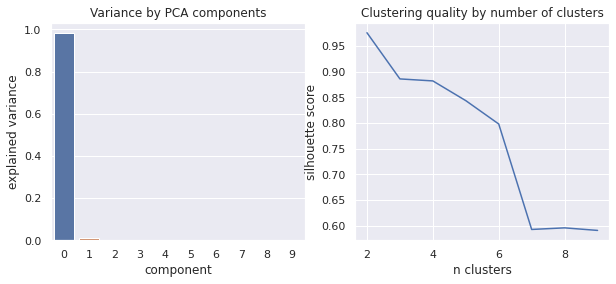

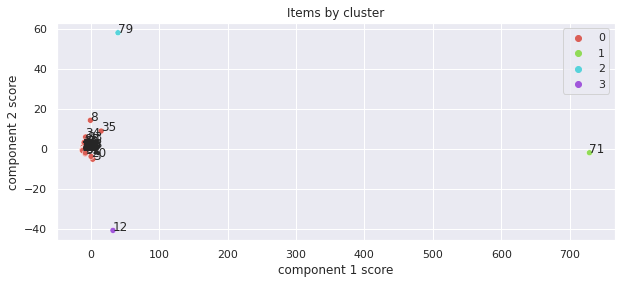

In [29]:
category_group_dict = cluster_feature(matrix, 'item_cnt_month', 'item_category_id', 'date_block_num', n_components=2, n_clusters=4, aggfunc="mean", exclude =[])
matrix['category_cluster'] = matrix['item_category_id'].map(category_group_dict)

Shops are clustered by their summed sales of each item category. The principle component plots show that shops mainly differ in the magnitude of their sales, with shop 31 being an outlier due to the volume of its sales. Shops 12 and 55 are outliers on an orthogonal dimension because they sell different (online only) items.

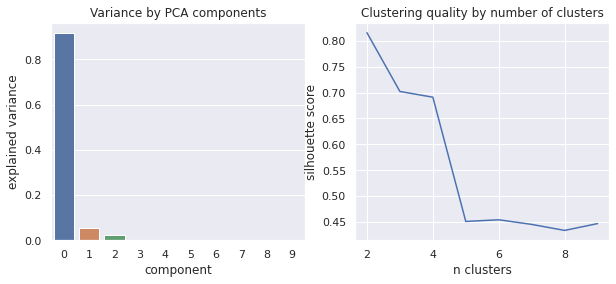

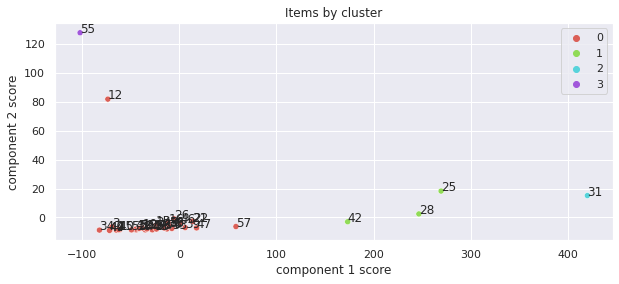

In [30]:
shop_group_dict = cluster_feature(matrix, 'item_cnt_month', 'shop_id', 'item_category_id', n_components=4, n_clusters=4, aggfunc="mean", exclude=[36])
shop_group_dict[36] = shop_group_dict[37]  # Shop36 added separately because it only has one month of data
matrix['shop_cluster'] = matrix['shop_id'].map(shop_group_dict)

In [31]:
gc.collect()
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)  # Use this function periodically to downcast dtypes to save memory

# Number of unique item features

These features count the number of unique items sharing the same value of a grouping feature or set of features as the current item in the current month, e.g. number of new items in the same category.  

This could considered to be a kind of data leakage feature, as the set of items in each month (and therefore the test set) is determined by whether each item recorded a sale or not in the month being predicted, which isn't known in advance.

In [32]:
def uniques(matrix, groupers, name, limitation=None):
    if limitation is not None:
        s = (
            matrix.query(limitation)
            .groupby(groupers)
            .item_id.nunique()
            .rename(name)
            .reset_index()
        )
    else:
        s = matrix.groupby(groupers).item_id.nunique().rename(name).reset_index()
    matrix = matrix.merge(s, on=groupers, how="left")
    matrix[name] = matrix[name].fillna(0)
    return matrix


matrix = uniques(matrix, ["date_block_num"], "unique_items_month")

matrix = uniques(matrix, ["date_block_num", "item_name_group"], "name_group_unique_month")
matrix = uniques(
    matrix,
    ["date_block_num", "item_category_id", "item_name_group"],
    "name_group_cat_unique_month",
)
matrix = uniques(
    matrix,
    ["date_block_num", "item_name_group"],
    "name_group_new_unique_month",
    limitation="new_item==True",
)
matrix = uniques(
    matrix,
    ["date_block_num", "item_category_id", "item_name_group"],
    "name_group_new_cat_unique_month",
    limitation="new_item==True",
)

matrix = uniques(
    matrix, ["date_block_num", "artist_name_or_first_word"], "first_word_unique_month"
)
matrix = uniques(
    matrix,
    ["date_block_num", "item_category_id", "artist_name_or_first_word"],
    "first_word_cat_unique_month",
)
matrix = uniques(
    matrix,
    ["date_block_num", "artist_name_or_first_word"],
    "first_word_new_unique_month",
    limitation="new_item==True",
)
matrix = uniques(
    matrix,
    ["date_block_num", "item_category_id", "artist_name_or_first_word"],
    "first_word_new_cat_unique_month",
    limitation="new_item==True",
)

matrix = uniques(matrix, ["date_block_num", "item_category_id"], "unique_items_cat")
matrix = uniques(
    matrix,
    ["date_block_num", "item_category_id"],
    "new_items_cat",
    limitation="new_item==True",
)
matrix = uniques(matrix, ["date_block_num"], "new_items_month", limitation="new_item==True")

matrix["cat_items_proportion"] = matrix["unique_items_cat"] / matrix["unique_items_month"]
matrix["name_group_new_proportion_month"] = (
    matrix["name_group_new_unique_month"] / matrix["name_group_unique_month"]
)

matrix = matrix.drop(columns=["unique_items_month", "name_group_unique_month"])

In [33]:
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)

# Percentage change in an aggregate feature  
This uses the pandas pct_change method to calculate the proportional change in mean sales count for a specific grouping for a specific time interval, e.g. increase / decrease in mean sales of an item between the last 2 months.

In [34]:
def add_pct_change(
    matrix,
    group_feats,
    target="item_cnt_month",
    aggfunc="mean",
    periods=1,
    lag=1,
    clip_value=None,
):
    periods = list_if_not(periods, int)
    group_feats = list_if_not(group_feats)
    group_feats_full = ["date_block_num"] + group_feats
    dat = matrix.pivot_table(
        index=group_feats + ["date_block_num"],
        values=target,
        aggfunc=aggfunc,
        fill_value=0,
        dropna=False,
    ).astype("float32")
    for g in group_feats:
        firsts = matrix.groupby(g).date_block_num.min().rename("firsts")
        dat = dat.merge(firsts, left_on=g, right_index=True, how="left")
        dat.loc[dat.index.get_level_values("date_block_num") < dat["firsts"], target] = float(
            "nan"
        )
        del dat["firsts"]
    for period in periods:
        feat_name = "_".join(
            group_feats + [target] + [aggfunc] + ["delta"] + [str(period)] + [f"lag_{lag}"]
        )
        print(f"Adding feature {feat_name}")
        dat = (
            dat.groupby(group_feats)[target]
            .transform(lambda x: x.pct_change(periods=period, fill_method="pad"))
            .rename(feat_name)
        )
        if clip_value is not None:
            dat = dat.clip(lower=-clip_value, upper=clip_value)
    dat = dat.reset_index()
    dat["date_block_num"] += lag
    matrix = matrix.merge(dat, on=["date_block_num"] + group_feats, how="left")
    matrix[feat_name] = reduce_mem_usage(matrix[feat_name])
    return matrix

In [35]:
matrix = add_pct_change(matrix, ["item_id"], "item_cnt_month", clip_value=3)
matrix = add_pct_change(matrix, ["item_category_id"], "item_cnt_month", clip_value=3)
matrix = add_pct_change(matrix, ["item_name_group"], "item_cnt_month", clip_value=3)
# Delta 1 feature lagged by 12 months, intended to capture seasonal trends
matrix = add_pct_change(matrix, ["item_category_id"], "item_cnt_month", lag=12, clip_value=3,)
gc.collect()

Adding feature item_id_item_cnt_month_mean_delta_1_lag_1
Adding feature item_category_id_item_cnt_month_mean_delta_1_lag_1
Adding feature item_name_group_item_cnt_month_mean_delta_1_lag_1
Adding feature item_category_id_item_cnt_month_mean_delta_1_lag_12


5

In [36]:
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)

# Windowed aggregates

Features aggregated over a specific window to reduce noise. Available windows are expanding (i.e. all preceding timepoints), rolling (i.e. fixed number of equally weighted timepoints) and exponentially weighted mean.  


A note about feature names: these are set automatically according to the pattern < grouping features > - < aggregated features > - < monthly aggregation function > - < window type > , where < window type > is either "rolling - < window aggregation function > - win - < window length in months >" for square rolling windows, "expanding - < window aggregation function >" for expanding windows, and "ewm_hl - < decay rate in terms of half-life > for exponential weighted means, all connected by underscores.

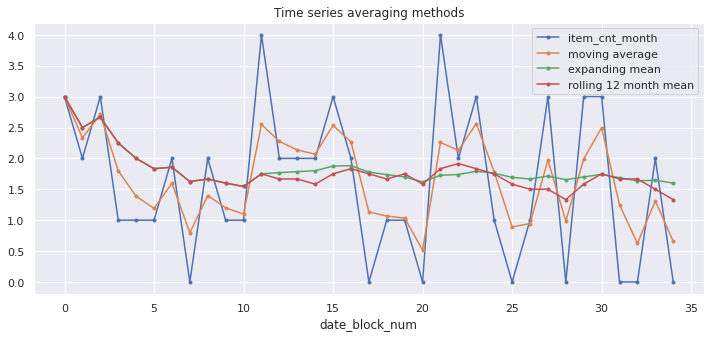

In [37]:
shop_id = 16
item_id = 482
im = matrix.query(f"shop_id=={shop_id} & item_id=={item_id}")[['date_block_num', 'item_cnt_month']]
im['moving average'] = im['item_cnt_month'].ewm(halflife=1).mean()
im['expanding mean'] = im['item_cnt_month'].expanding().mean()
im['rolling 12 month mean'] = im['item_cnt_month'].rolling(window=12, min_periods=1).mean()
im = im.set_index('date_block_num')
ax = im.plot(figsize=(12,5), marker='.', title='Time series averaging methods')

In [38]:
def add_rolling_stats(
    matrix,
    features,
    window=12,
    kind="rolling",
    argfeat="item_cnt_month",
    aggfunc="mean",
    rolling_aggfunc="mean",
    dtype="float16",
    reshape_source=True,
    lag_offset=0,
):
    def rolling_stat(
        matrix,
        source,
        feats,
        feat_name,
        window=12,
        argfeat="item_cnt_month",
        aggfunc="mean",
        dtype=dtype,
        lag_offset=0,
    ):
        # Calculate a statistic on a windowed section of a source table,  grouping on specific features
        store = []
        for i in range(2 + lag_offset, 35 + lag_offset):
            if len(feats) > 0:
                mes = (
                    source[source.date_block_num.isin(range(max([i - window, 0]), i))]
                    .groupby(feats)[argfeat]
                    .agg(aggfunc)
                    .astype(dtype)
                    .rename(feat_name)
                    .reset_index()
                )
            else:
                mes = {}
                mes[feat_name] = (
                    source.loc[
                        source.date_block_num.isin(range(max([i - window, 0]), i)), argfeat
                    ]
                    .agg(aggfunc)
                    .astype(dtype)
                )
                mes = pd.DataFrame(data=mes, index=[i])
            mes["date_block_num"] = i - lag_offset
            store.append(mes)
        store = pd.concat(store)
        matrix = matrix.merge(store, on=feats + ["date_block_num"], how="left")
        return matrix

    """ An issue when using windowed functions is that missing values from months when items recorded no sales are skipped rather than being correctly
    treated as zeroes. Creating a pivot_table fills in the zeros."""
    if (reshape_source == True) or (kind == "ewm"):
        source = matrix.pivot_table(
            index=features + ["date_block_num"],
            values=argfeat,
            aggfunc=aggfunc,
            fill_value=0,
            dropna=False,
        ).astype(dtype)
        for g in features:
            firsts = matrix.groupby(g).date_block_num.min().rename("firsts")
            source = source.merge(firsts, left_on=g, right_index=True, how="left")
            # Set values before the items first appearance to nan so they are ignored rather than being treated as zero sales.
            source.loc[
                source.index.get_level_values("date_block_num") < source["firsts"], argfeat
            ] = float("nan")
            del source["firsts"]
        source = source.reset_index()
    else:
        source = matrix

    if kind == "rolling":
        feat_name = (
            f"{'_'.join(features)}_{argfeat}_{aggfunc}_rolling_{rolling_aggfunc}_win_{window}"
        )
        print(f'Creating feature "{feat_name}"')
        return rolling_stat(
            matrix,
            source,
            features,
            feat_name,
            window=window,
            argfeat=argfeat,
            aggfunc=rolling_aggfunc,
            dtype=dtype,
            lag_offset=lag_offset,
        )
    elif kind == "expanding":
        feat_name = f"{'_'.join(features)}_{argfeat}_{aggfunc}_expanding_{rolling_aggfunc}"
        print(f'Creating feature "{feat_name}"')
        return rolling_stat(
            matrix,
            source,
            features,
            feat_name,
            window=100,
            argfeat=argfeat,
            aggfunc=aggfunc,
            dtype=dtype,
            lag_offset=lag_offset,
        )
    elif kind == "ewm":
        feat_name = f"{'_'.join(features)}_{argfeat}_{aggfunc}_ewm_hl_{window}"
        print(f'Creating feature "{feat_name}"')
        source[feat_name] = (
            source.groupby(features)[argfeat]
            .ewm(halflife=window, min_periods=1)
            .agg(rolling_aggfunc)
            .to_numpy(dtype=dtype)
        )
        del source[argfeat]
        #         source = source.reset_index()
        source["date_block_num"] += 1 - lag_offset
        return matrix.merge(source, on=["date_block_num"] + features, how="left")

Create rolling mean features. The combinations of grouping features and window types here were selected by generating a large number of features and then pruning them with the scikit-learn RFECV function.

In [39]:
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "artist_name_or_first_word", "item_category_id", "item_age"],
    window=12,
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "artist_name_or_first_word", "item_category_id", "new_item"],
    kind="expanding",
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "artist_name_or_first_word", "new_item"],
    kind="expanding",
    reshape_source=False,
)
matrix = add_rolling_stats(matrix, ["shop_id", "category_cluster"], window=12)
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "item_category_id", "item_age"],
    kind="expanding",
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix, ["shop_id", "item_category_id", "item_age"], window=12, reshape_source=False
)
matrix = add_rolling_stats(matrix, ["shop_id", "item_category_id"], kind="ewm", window=1)
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "item_category_id", "new_item"],
    kind="expanding",
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix, ["shop_id", "item_category_id", "new_item"], window=12, reshape_source=False
)
matrix = add_rolling_stats(matrix, ["shop_id"], window=12)
matrix = add_rolling_stats(matrix, ["shop_id", "item_id"], kind="ewm", window=1)
matrix = add_rolling_stats(matrix, ["shop_id", "item_id"], window=12)
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "item_name_group", "item_category_id", "new_item"],
    window=12,
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix, ["shop_id", "item_name_group", "new_item"], kind="expanding", reshape_source=False
)
matrix = add_rolling_stats(
    matrix, ["shop_id", "supercategory_id", "new_item"], window=12, reshape_source=False
)

matrix = add_rolling_stats(matrix, ["shop_cluster", "item_id"], kind="ewm", window=1)
matrix = add_rolling_stats(
    matrix,
    ["shop_cluster", "item_category_id", "item_age"],
    kind="expanding",
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix, ["shop_cluster", "item_name_group", "new_item"], window=12, reshape_source=False
)

matrix = add_rolling_stats(
    matrix, ["category_cluster", "item_age"], kind="expanding", reshape_source=False
)
matrix = add_rolling_stats(
    matrix, ["category_cluster", "new_item"], kind="expanding", reshape_source=False
)

matrix = add_rolling_stats(matrix, ["item_id"], window=12)

matrix = add_rolling_stats(matrix, ["artist_name_or_first_word"], window=12)
matrix = add_rolling_stats(matrix, ["artist_name_or_first_word"], kind="ewm", window=1)
matrix = add_rolling_stats(
    matrix, ["artist_name_or_first_word", "item_age"], window=12, reshape_source=False
)
matrix = add_rolling_stats(
    matrix,
    ["artist_name_or_first_word", "item_category_id", "item_age"],
    window=12,
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix, ["artist_name_or_first_word", "new_item"], kind="expanding", reshape_source=False
)

matrix = add_rolling_stats(
    matrix, ["item_category_id", "item_age"], kind="expanding", reshape_source=False
)
matrix = add_rolling_stats(matrix, ["item_category_id"], window=12)
matrix = add_rolling_stats(matrix, ["item_category_id"], kind="ewm", window=1)
matrix = add_rolling_stats(
    matrix, ["item_category_id", "new_item"], kind="expanding", reshape_source=False
)

matrix = add_rolling_stats(
    matrix, ["item_name_group", "item_age"], window=12, reshape_source=False
)
matrix = add_rolling_stats(matrix, ["item_name_group"], kind="ewm", window=1)
matrix = add_rolling_stats(matrix, ["item_name_group"], window=12)

matrix = add_rolling_stats(matrix, ["platform_id"], window=12)
matrix = add_rolling_stats(matrix, ["platform_id"], kind="ewm", window=1)

Creating feature "shop_id_artist_name_or_first_word_item_category_id_item_age_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "shop_id_artist_name_or_first_word_item_category_id_new_item_item_cnt_month_mean_expanding_mean"
Creating feature "shop_id_artist_name_or_first_word_new_item_item_cnt_month_mean_expanding_mean"
Creating feature "shop_id_category_cluster_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "shop_id_item_category_id_item_age_item_cnt_month_mean_expanding_mean"
Creating feature "shop_id_item_category_id_item_age_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "shop_id_item_category_id_item_cnt_month_mean_ewm_hl_1"
Creating feature "shop_id_item_category_id_new_item_item_cnt_month_mean_expanding_mean"
Creating feature "shop_id_item_category_id_new_item_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "shop_id_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "shop_id_item_id_item_cnt_month_mean_ewm_hl_1"
Creating feature "sh

In [40]:
gc.collect()
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)

matrix.to_pickle("matrixcheckpoint1.pkl")
print("Saved matrixcheckpoint")
gc.collect()

print("Widnow aggregate features created")

Saved matrixcheckpoint
Widnow aggregate features created


The following code block calculates windowed mean sales features with day resolution accuracy

In [41]:
# Summed sales & accurate windowed mean sales per day features
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "item_id"],
    aggfunc="sum",
    rolling_aggfunc="sum",
    kind="rolling",
    window=12,
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix,
    ["item_id"],
    aggfunc="sum",
    rolling_aggfunc="sum",
    kind="expanding",
    reshape_source=False,
)
matrix["1year"] = 365
matrix["item_id_day_mean_expanding"] = matrix[
    "item_id_item_cnt_month_sum_expanding_sum"
] / matrix[["first_item_sale_days"]].min(axis=1)
matrix["shop_id_item_id_day_mean_win_12"] = matrix[
    "shop_id_item_id_item_cnt_month_sum_rolling_sum_win_12"
] / matrix[["first_item_sale_days", "shop_open_days", "1year"]].min(axis=1)
matrix.loc[matrix.new_item == True, "item_id_day_mean_expanding",] = float("nan")
matrix = matrix.drop(columns=["1year", "item_id_item_cnt_month_sum_expanding_sum"])

Creating feature "shop_id_item_id_item_cnt_month_sum_rolling_sum_win_12"
Creating feature "item_id_item_cnt_month_sum_expanding_sum"


Revenue features

In [42]:
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "item_name_group"],
    window=12,
    argfeat="item_revenue_month",
    dtype="float32",
)

Creating feature "shop_id_item_name_group_item_revenue_month_mean_rolling_mean_win_12"


Windowed mean unique item features and ratio of new items in category with mean over the previous year

In [43]:
matrix = add_rolling_stats(
    matrix,
    ["item_category_id"],
    argfeat="new_items_cat",
    window=12,
    reshape_source=True,
    lag_offset=1,
)
matrix = add_rolling_stats(
    matrix,
    ["item_name_group"],
    argfeat="name_group_new_unique_month",
    window=12,
    reshape_source=True,
    lag_offset=1,
)

matrix["new_items_cat_1_12_ratio"] = (
    matrix["new_items_cat"]
    / matrix["item_category_id_new_items_cat_mean_rolling_mean_win_12"]
)

Creating feature "item_category_id_new_items_cat_mean_rolling_mean_win_12"
Creating feature "item_name_group_name_group_new_unique_month_mean_rolling_mean_win_12"


In [44]:
gc.collect()
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)

# Lagged features and mean encodings  
Values for the same shop-item combination from previous months

In [45]:
def simple_lag_feature(matrix, lag_feature, lags):
    for lag in lags:
        newname = lag_feature + f"_lag_{lag}"
        print(f"Adding feature {newname}")
        targetseries = matrix.loc[:, ["date_block_num", "item_id", "shop_id"] + [lag_feature]]
        targetseries["date_block_num"] += lag
        targetseries = targetseries.rename(columns={lag_feature: newname})
        matrix = matrix.merge(
            targetseries, on=["date_block_num", "item_id", "shop_id"], how="left"
        )
        matrix.loc[
            (matrix.item_age >= lag) & (matrix.shop_age >= lag) & (matrix[newname].isna()),
            newname,
        ] = 0
    return matrix

In [46]:
matrix = simple_lag_feature(matrix, 'item_cnt_month', lags=[1, 2, 3])
matrix = simple_lag_feature(matrix, 'item_cnt_day_avg', lags=[1, 2, 3])
matrix = simple_lag_feature(matrix, 'item_revenue_month', lags=[1])
gc.collect()
print("Lag features created")

Adding feature item_cnt_month_lag_1
Adding feature item_cnt_month_lag_2
Adding feature item_cnt_month_lag_3
Adding feature item_cnt_day_avg_lag_1
Adding feature item_cnt_day_avg_lag_2
Adding feature item_cnt_day_avg_lag_3
Adding feature item_revenue_month_lag_1
Lag features created


## Mean encodings
The mean or sum value of a target feature for each level of a categorical feature or combination of categorical features, lagged

In [47]:
def create_apply_ME(
    matrix, grouping_fields, lags=[1], target="item_cnt_day_avg", aggfunc="mean"
):
    grouping_fields = list_if_not(grouping_fields)
    for lag in lags:
        newname = "_".join(grouping_fields + [target] + [aggfunc] + [f"lag_{lag}"])
        print(f"Adding feature {newname}")
        me_series = (
            matrix.groupby(["date_block_num"] + grouping_fields)[target]
            .agg(aggfunc)
            .rename(newname)
            .reset_index()
        )
        me_series["date_block_num"] += lag
        matrix = matrix.merge(me_series, on=["date_block_num"] + grouping_fields, how="left")
        del me_series
        matrix[newname] = matrix[newname].fillna(0)
        for g in grouping_fields:
            firsts = matrix.groupby(g).date_block_num.min().rename("firsts")
            matrix = matrix.merge(firsts, left_on=g, right_index=True, how="left")
            matrix.loc[
                matrix["date_block_num"] < (matrix["firsts"] + (lag)), newname
            ] = float("nan")
            del matrix["firsts"]
        matrix[newname] = reduce_mem_usage(matrix[newname])
    return matrix

In [48]:
matrix = create_apply_ME(matrix, ["item_name_group"], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["item_name_group"], target="item_cnt_month", aggfunc="sum")
matrix = create_apply_ME(matrix, ["item_id"], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["item_id"])
matrix = create_apply_ME(matrix, ["platform_id"])
matrix = create_apply_ME(matrix, ["item_name_group"])
matrix = create_apply_ME(matrix, ["platform_id"], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["supercategory_id"])
matrix = create_apply_ME(matrix, ["item_category_id", "new_item"], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["shop_id", "item_category_id"], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["shop_cluster", "item_id"], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["shop_cluster", "item_id"])
matrix = create_apply_ME(matrix, ["city_code", "item_id"])
matrix = create_apply_ME(matrix, ["city_code", "item_name_group"])
matrix = create_apply_ME(matrix, ["shop_type", "item_id"])
matrix = create_apply_ME(matrix, ["shop_type", "item_id"], target="item_cnt_month")

Adding feature item_name_group_item_cnt_month_mean_lag_1
Adding feature item_name_group_item_cnt_month_sum_lag_1
Adding feature item_id_item_cnt_month_mean_lag_1
Adding feature item_id_item_cnt_day_avg_mean_lag_1
Adding feature platform_id_item_cnt_day_avg_mean_lag_1
Adding feature item_name_group_item_cnt_day_avg_mean_lag_1
Adding feature platform_id_item_cnt_month_mean_lag_1
Adding feature supercategory_id_item_cnt_day_avg_mean_lag_1
Adding feature item_category_id_new_item_item_cnt_month_mean_lag_1
Adding feature shop_id_item_category_id_item_cnt_month_mean_lag_1
Adding feature shop_cluster_item_id_item_cnt_month_mean_lag_1
Adding feature shop_cluster_item_id_item_cnt_day_avg_mean_lag_1
Adding feature city_code_item_id_item_cnt_day_avg_mean_lag_1
Adding feature city_code_item_name_group_item_cnt_day_avg_mean_lag_1
Adding feature shop_type_item_id_item_cnt_day_avg_mean_lag_1
Adding feature shop_type_item_id_item_cnt_month_mean_lag_1


Ratios between lag 1 sales and rolling 12 month means, to capture decreases from previous means

In [49]:
matrix["item_id_item_cnt_1_12_ratio"] = (
    matrix["item_id_item_cnt_month_mean_lag_1"]
    / matrix["item_id_item_cnt_month_mean_rolling_mean_win_12"]
)
matrix["shop_id_item_id_item_cnt_1_12_ratio"] = (
    matrix["item_cnt_day_avg_lag_1"] / matrix["shop_id_item_id_day_mean_win_12"]
)

In [50]:
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)
matrix.to_pickle("matrixcheckpoint2.pkl")
print("Saved matrixcheckpoint")
gc.collect()
print("Mean encoding features created")

Saved matrixcheckpoint
Mean encoding features created


Some columns that were used to generate other features can now be discarded.

In [51]:
surplus_columns = [
    "item_revenue_month",
    "item_cnt_day_avg",
    "item_name_group",
    "artist_name_or_first_word",
    "item_age",
    "shop_open_days",
    "shop_age",
    "platform_id",
    "supercategory_id",
    "city_code",
    "category_cluster",
    "shop_cluster",
    "shop_type",
    "new_items_cat",
    "shop_id_item_id_day_mean_win_12",
    "item_id_item_cnt_month_mean_rolling_mean_win_12",
]
matrix = matrix.drop(columns=surplus_columns)

# Predictive words in item_name

One-hot features are made for words in the item_name field that are predictive of item sales.  

To select *k* word features from the 1000's of words found in item names, words are discarded if they are not in the names of a threshold number of items, or are not in the names of new items in the test or validation months. Remaining words are then selected by the scikit-learn SelectKBest function according to their correlation with the target.

In [52]:
import re
import warnings

warnings.filterwarnings("ignore", module="sklearn")

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, f_regression


def name_token_feats(matrix, items, k=50, item_n_threshold=5, target_month_start=33):
    def name_correction(st):
        st = re.sub(r"[^\w\s]", "", st)
        st = re.sub(r"\s{2,}", " ", st)
        st = st.lower().strip()
        return st

    items["item_name_clean"] = items["item_name"].apply(name_correction)

    def create_item_id_bow_matrix(items):
        all_stopwords = stopwords.words("russian")
        all_stopwords = all_stopwords + stopwords.words("english")

        vectorizer = CountVectorizer(stop_words=all_stopwords)
        X = vectorizer.fit_transform(items.loc[:, "item_name_clean"])
        X = pd.DataFrame.sparse.from_spmatrix(X)
        print(f"{len(vectorizer.vocabulary_)} words found in all items")
        featuremap = {
            col: "word_" + token
            for col, token in zip(
                range(len(vectorizer.vocabulary_)), vectorizer.get_feature_names()
            )
        }
        X = X.rename(columns=featuremap)
        return X

    items_bow = create_item_id_bow_matrix(items)
    items_bow = items_bow.clip(0, 1)  # Made the word counts binary
    common_word_mask = items_bow.sum(axis=0) > item_n_threshold
    target_items = matrix.query(
        f"date_block_num>={target_month_start} & new_item==True"
    ).item_id.unique()
    target_item_mask = items_bow.loc[target_items, :].sum(axis=0) > 1
    items_bow = items_bow.loc[:, common_word_mask & target_item_mask]
    print(f"{items_bow.shape[1]} words of interest")
    mxbow = matrix[["date_block_num", "item_id", "item_cnt_month"]].query("date_block_num<34")
    mxbow = mxbow.merge(items_bow, left_on="item_id", right_index=True, how="left")
    X = mxbow.drop(columns=["date_block_num", "item_id", "item_cnt_month"])
    y = mxbow["item_cnt_month"].clip(0, 20)
    selektor = SelectKBest(f_regression, k=k)
    selektor.fit(X, y)
    tokencols = X.columns[selektor.get_support()]
    print(f"{k} word features selected")
    return items_bow[tokencols]

In [53]:
items = pd.read_csv("items.csv.zip")
word_frame = name_token_feats(matrix, items, k=50, item_n_threshold=5)
matrix = matrix.merge(word_frame, left_on='item_id', right_index=True, how='left')
# LightGBM didn't seem to work with sparse features in this case, so we'll convert them to int
sparsecols = [c for c in matrix.columns if pd.api.types.is_sparse(matrix[c].dtype)]
matrix[sparsecols] = matrix[sparsecols].sparse.to_dense().astype('int8')

19134 words found in all items
449 words of interest
50 word features selected


The final feature frame is saved and the notebook kernel is reset to free up memory for LightGBM.

In [54]:
gc.collect()
matrix.to_pickle("checkpoint_final.pkl")
print("All features generated, dataframe saved")

All features generated, dataframe saved


In [55]:
%reset -f

# Model fitting

In [1]:
import os
import gc
import numpy as np
import pandas as pd
import multiprocessing as mp
from tqdm.notebook import tqdm as tqdm_notebook
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings("ignore", module="lightgbm")

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

The feature frame is loaded and the target is clipped to match the test items

In [2]:
matrix = pd.read_pickle("checkpoint_final.pkl")
matrix['item_cnt_month'] = matrix['item_cnt_month'].clip(0,20)
# drop first 2 months
matrix = matrix[matrix.date_block_num >= 2]

### Optimize the model with Optuna

In [4]:
import optuna
import optuna.integration.lightgbm as lgb

params = {
    'objective': 'mse',
    'metric': 'rmse',
    'verbose': 1,
    'device': 'gpu',
    'gpu_platform_id': 0,
    'gpu_device_id': 0
}
cat_feats = ['item_category_id', 'month', 'season']

last_block = 33
dates = matrix['date_block_num']

# drop target and some features that lead to overfitting
cols_to_drop = ['item_cnt_month', 'new_item', 'shop_id', 'item_id']

# split dataset on train and test sets for model training
X_train = matrix.loc[dates <  last_block].drop(cols_to_drop, axis=1)
X_val = matrix.loc[dates ==  last_block].drop(cols_to_drop, axis=1)
X_test = matrix.loc[dates ==  34].drop(cols_to_drop, axis=1)

y_train = matrix.loc[dates <  last_block, 'item_cnt_month']
y_val = matrix.loc[dates ==  last_block, 'item_cnt_month']

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

study = optuna.create_study()

gbm = lgb.train(
        params,
        lgb_train,
        num_boost_round=8000,
        study = study,
        valid_sets=(lgb_train, lgb_eval), 
        categorical_feature = cat_feats,
        verbose_eval=50, 
        early_stopping_rounds=30,
)

[I 2021-08-27 13:44:57,059] A new study created in memory with name: no-name-92cb9254-4c8b-4de4-b81a-fd6bf8e72af8
feature_fraction, val_score: inf:   0%|                   | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.317404 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.802652	valid_1's rmse: 0.735579
[100]	valid_0's rmse: 0.767314	valid_1's rmse: 0.726061
[150]	valid_0's rmse: 0.747089	valid_1's rmse: 0.717437
[200]	valid_0's rmse: 0.73491	valid_1's rmse: 0.715937
[250]	valid_0's rmse: 0.725592	valid_1's rmse: 0.714783


feature_fraction, val_score: 0.714146:  14%|8     | 1/7 [01:12<07:17, 72.90s/it]

[300]	valid_0's rmse: 0.716956	valid_1's rmse: 0.716025
Early stopping, best iteration is:
[270]	valid_0's rmse: 0.722018	valid_1's rmse: 0.714146
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.298833 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.79583	valid_1's rmse: 0.725896
[100]	valid_0's rmse: 0.759987	valid_1's rmse: 0.71469
[150]	valid_0's rmse: 0.741704	valid

feature_fraction, val_score: 0.711117:  29%|#7    | 2/7 [02:00<04:48, 57.76s/it]

Early stopping, best iteration is:
[163]	valid_0's rmse: 0.738138	valid_1's rmse: 0.711117
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.317572 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.796561	valid_1's rmse: 0.732604
[100]	valid_0's rmse: 0.758703	valid_1's rmse: 0.72238
[150]	valid_0's rmse: 0.740022	valid_1's rmse: 0.718583
[200]	valid_0's rmse: 0.727775	vali

feature_fraction, val_score: 0.711117:  43%|##5   | 3/7 [02:52<03:41, 55.41s/it]

Early stopping, best iteration is:
[207]	valid_0's rmse: 0.726139	valid_1's rmse: 0.714956
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.313539 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.796147	valid_1's rmse: 0.731761
[100]	valid_0's rmse: 0.759518	valid_1's rmse: 0.721542
[150]	valid_0's rmse: 0.740954	valid_1's rmse: 0.716679
[200]	valid_0's rmse: 0.728309	val

feature_fraction, val_score: 0.711117:  57%|###4  | 4/7 [03:46<02:44, 54.83s/it]

Early stopping, best iteration is:
[222]	valid_0's rmse: 0.723681	valid_1's rmse: 0.715053
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.292269 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.800601	valid_1's rmse: 0.733891
[100]	valid_0's rmse: 0.763134	valid_1's rmse: 0.725954
[150]	valid_0's rmse: 0.743978	valid_1's rmse: 0.720911
[200]	valid_0's rmse: 0.729848	val

feature_fraction, val_score: 0.711117:  71%|####2 | 5/7 [04:41<01:49, 54.99s/it]

Early stopping, best iteration is:
[193]	valid_0's rmse: 0.731607	valid_1's rmse: 0.717783
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.295058 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.799158	valid_1's rmse: 0.727887
[100]	valid_0's rmse: 0.764186	valid_1's rmse: 0.717028
[150]	valid_0's rmse: 0.745654	valid_1's rmse: 0.714541


feature_fraction, val_score: 0.711117:  86%|#####1| 6/7 [05:31<00:53, 53.16s/it]

Early stopping, best iteration is:
[133]	valid_0's rmse: 0.751198	valid_1's rmse: 0.714218
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.298319 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.799152	valid_1's rmse: 0.73385
[100]	valid_0's rmse: 0.761956	valid_1's rmse: 0.724978
[150]	valid_0's rmse: 0.743768	valid_1's rmse: 0.720511
[200]	valid_0's rmse: 0.731849	vali

feature_fraction, val_score: 0.711117: 100%|######| 7/7 [06:37<00:00, 56.83s/it]


Early stopping, best iteration is:
[331]	valid_0's rmse: 0.707494	valid_1's rmse: 0.714052


num_leaves, val_score: 0.711117:   0%|                   | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.298125 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.801578	valid_1's rmse: 0.736309
[100]	valid_0's rmse: 0.764107	valid_1's rmse: 0.725817
[150]	valid_0's rmse: 0.745352	valid_1's rmse: 0.721307


num_leaves, val_score: 0.711117:   5%|5          | 1/20 [00:43<13:54, 43.91s/it]

Early stopping, best iteration is:
[140]	valid_0's rmse: 0.7487	valid_1's rmse: 0.720506
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.288982 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.712765	valid_1's rmse: 0.722927
[100]	valid_0's rmse: 0.672603	valid_1's rmse: 0.720382


num_leaves, val_score: 0.711117:  10%|#1         | 2/20 [01:33<14:08, 47.15s/it]

Early stopping, best iteration is:
[83]	valid_0's rmse: 0.682315	valid_1's rmse: 0.719618
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.303195 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.808912	valid_1's rmse: 0.739706
[100]	valid_0's rmse: 0.773376	valid_1's rmse: 0.728735
[150]	valid_0's rmse: 0.755668	valid_1's rmse: 0.723423
[200]	valid_0's rmse: 0.742424	vali

num_leaves, val_score: 0.711117:  15%|#6         | 3/20 [02:22<13:39, 48.23s/it]

Early stopping, best iteration is:
[203]	valid_0's rmse: 0.741668	valid_1's rmse: 0.721793
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.291636 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.723275	valid_1's rmse: 0.722445
[100]	valid_0's rmse: 0.685051	valid_1's rmse: 0.718961


num_leaves, val_score: 0.711117:  20%|##2        | 4/20 [03:18<13:37, 51.07s/it]

[150]	valid_0's rmse: 0.662356	valid_1's rmse: 0.717422
Early stopping, best iteration is:
[120]	valid_0's rmse: 0.673951	valid_1's rmse: 0.717027
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.314710 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.717634	valid_1's rmse: 0.727559
[100]	valid_0's rmse: 0.678458	valid_1's rmse: 0.725272


num_leaves, val_score: 0.711117:  25%|##7        | 5/20 [04:11<12:56, 51.79s/it]

Early stopping, best iteration is:
[96]	valid_0's rmse: 0.681106	valid_1's rmse: 0.724758
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.302676 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.708676	valid_1's rmse: 0.721104
[100]	valid_0's rmse: 0.668099	valid_1's rmse: 0.717209


num_leaves, val_score: 0.711117:  30%|###3       | 6/20 [05:07<12:26, 53.30s/it]

Early stopping, best iteration is:
[96]	valid_0's rmse: 0.670166	valid_1's rmse: 0.716923
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.311547 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.75059	valid_1's rmse: 0.720254


num_leaves, val_score: 0.711117:  35%|###8       | 7/20 [05:47<10:36, 48.95s/it]

Early stopping, best iteration is:
[60]	valid_0's rmse: 0.739928	valid_1's rmse: 0.716805
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.294688 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.727935	valid_1's rmse: 0.723298
[100]	valid_0's rmse: 0.688623	valid_1's rmse: 0.718879


num_leaves, val_score: 0.711117:  40%|####4      | 8/20 [06:39<09:58, 49.83s/it]

Early stopping, best iteration is:
[104]	valid_0's rmse: 0.686517	valid_1's rmse: 0.7188
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.290935 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.70399	valid_1's rmse: 0.718056
[100]	valid_0's rmse: 0.664512	valid_1's rmse: 0.715178


num_leaves, val_score: 0.711117:  45%|####9      | 9/20 [07:35<09:29, 51.79s/it]

Early stopping, best iteration is:
[106]	valid_0's rmse: 0.661662	valid_1's rmse: 0.714883
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.292246 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.700679	valid_1's rmse: 0.723555
[100]	valid_0's rmse: 0.658769	valid_1's rmse: 0.719025
[150]	valid_0's rmse: 0.63566	valid_1's rmse: 0.71735


num_leaves, val_score: 0.711117:  50%|#####     | 10/20 [08:38<09:11, 55.18s/it]

Early stopping, best iteration is:
[136]	valid_0's rmse: 0.640591	valid_1's rmse: 0.716912
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.287458 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.703543	valid_1's rmse: 0.716509
[100]	valid_0's rmse: 0.663188	valid_1's rmse: 0.712534


num_leaves, val_score: 0.711117:  55%|#####5    | 11/20 [09:30<08:07, 54.19s/it]

Early stopping, best iteration is:
[86]	valid_0's rmse: 0.672042	valid_1's rmse: 0.71193
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.287514 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.698113	valid_1's rmse: 0.725738
[100]	valid_0's rmse: 0.656554	valid_1's rmse: 0.725357
Early stopping, best iteration is:
[71]	valid_0's rmse: 0.676874	valid_1's rmse: 0.724947


num_leaves, val_score: 0.711117:  60%|######    | 12/20 [10:19<07:02, 52.81s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.289249 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.705596	valid_1's rmse: 0.725355
[100]	valid_0's rmse: 0.665742	valid_1's rmse: 0.720987


num_leaves, val_score: 0.711117:  65%|######5   | 13/20 [11:08<06:00, 51.57s/it]

Early stopping, best iteration is:
[75]	valid_0's rmse: 0.681858	valid_1's rmse: 0.720221
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.292450 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.750885	valid_1's rmse: 0.718497
[100]	valid_0's rmse: 0.71562	valid_1's rmse: 0.713373
[150]	valid_0's rmse: 0.695276	valid_1's rmse: 0.713188


num_leaves, val_score: 0.711117:  70%|#######   | 14/20 [11:56<05:03, 50.57s/it]

Early stopping, best iteration is:
[124]	valid_0's rmse: 0.704293	valid_1's rmse: 0.712487
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.302741 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.747715	valid_1's rmse: 0.719906
[100]	valid_0's rmse: 0.710462	valid_1's rmse: 0.715408
[150]	valid_0's rmse: 0.691395	valid_1's rmse: 0.713517


num_leaves, val_score: 0.711117:  75%|#######5  | 15/20 [12:45<04:10, 50.05s/it]

Early stopping, best iteration is:
[135]	valid_0's rmse: 0.696007	valid_1's rmse: 0.713193
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.303535 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.742004	valid_1's rmse: 0.727409


num_leaves, val_score: 0.711117:  80%|########  | 16/20 [13:23<03:05, 46.47s/it]

Early stopping, best iteration is:
[54]	valid_0's rmse: 0.737054	valid_1's rmse: 0.72609
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.287660 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.765521	valid_1's rmse: 0.721198
[100]	valid_0's rmse: 0.72948	valid_1's rmse: 0.712096


num_leaves, val_score: 0.711117:  85%|########5 | 17/20 [14:05<02:15, 45.04s/it]

Early stopping, best iteration is:
[99]	valid_0's rmse: 0.729976	valid_1's rmse: 0.711905
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.290050 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.875867	valid_1's rmse: 0.786395
[100]	valid_0's rmse: 0.848207	valid_1's rmse: 0.765745
[150]	valid_0's rmse: 0.830905	valid_1's rmse: 0.758222
[200]	valid_0's rmse: 0.817434	vali

num_leaves, val_score: 0.711117:  90%|######### | 18/20 [14:57<01:34, 47.26s/it]

Early stopping, best iteration is:
[349]	valid_0's rmse: 0.795231	valid_1's rmse: 0.733845
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.293490 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.768618	valid_1's rmse: 0.726678
[100]	valid_0's rmse: 0.732501	valid_1's rmse: 0.718225
[150]	valid_0's rmse: 0.713616	valid_1's rmse: 0.716359


num_leaves, val_score: 0.711117:  95%|#########5| 19/20 [15:46<00:47, 47.61s/it]

Early stopping, best iteration is:
[154]	valid_0's rmse: 0.71182	valid_1's rmse: 0.715681
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.292291 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.73601	valid_1's rmse: 0.717842
[100]	valid_0's rmse: 0.697647	valid_1's rmse: 0.711213


num_leaves, val_score: 0.710346: 100%|##########| 20/20 [16:31<00:00, 49.58s/it]


Early stopping, best iteration is:
[95]	valid_0's rmse: 0.70053	valid_1's rmse: 0.710346


bagging, val_score: 0.710346:   0%|                      | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.286745 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (486.28 MB) transferred to GPU in 0.256377 secs. 1 sparse feature groups
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (486.07 MB) transferred to GPU in 0.2

[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (486.05 MB) transferred to GPU in 0.239631 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (486.10 MB) transferred to GPU in 0.238559 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (486.07 MB) transferred to GPU in 0.235423 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (486.04 MB) transferred to GPU in 0.237829 secs. 1 sparse feature groups
[100]	valid_0's rmse: 0.698844	valid_1's rmse: 0.714939
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (485.79 MB) transferred to GPU in 0.236797 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (486.02 MB) transferred to GPU in

bagging, val_score: 0.710346:  10%|#4            | 1/10 [01:37<14:37, 97.51s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.302144 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (267.25 MB) transferred to GPU in 0.129645 secs. 1 sparse feature groups
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (267.01 MB) transferred to GPU in 0.1

bagging, val_score: 0.710346:  20%|##8           | 2/10 [02:43<10:32, 79.08s/it]

Early stopping, best iteration is:
[139]	valid_0's rmse: 0.690201	valid_1's rmse: 0.71954
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.291184 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (373.83 MB) transferred to GPU in 0.180987 secs. 1 sparse feature groups
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Size of histogram bi

bagging, val_score: 0.710346:  30%|####2         | 3/10 [03:40<08:03, 69.13s/it]

Early stopping, best iteration is:
[90]	valid_0's rmse: 0.707181	valid_1's rmse: 0.724765
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.303422 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (283.45 MB) transferred to GPU in 0.143208 secs. 1 sparse feature groups
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Size of histogram bi

bagging, val_score: 0.710346:  40%|#####6        | 4/10 [04:25<05:57, 59.57s/it]

Early stopping, best iteration is:
[61]	valid_0's rmse: 0.729327	valid_1's rmse: 0.721142
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.297202 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.51 MB) transferred to GPU in 0.196716 secs. 1 sparse feature groups
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Size of histogram bi

[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.25 MB) transferred to GPU in 0.195834 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.26 MB) transferred to GPU in 0.194424 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.20 MB) transferred to GPU in 0.205269 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.24 MB) transferred to GPU in 0.196745 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.21 MB) transferred to GPU in 0.195757 secs. 1 sparse feature groups
[150]	valid_0's rmse: 0.680568	valid_1's rmse: 0.707608
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (407.83 MB) transferred to GPU in

bagging, val_score: 0.706255:  50%|#######       | 5/10 [05:58<05:57, 71.50s/it]

Early stopping, best iteration is:
[171]	valid_0's rmse: 0.67499	valid_1's rmse: 0.706255
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.291713 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (281.55 MB) transferred to GPU in 0.135162 secs. 1 sparse feature groups
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Size of histogram bi

[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (281.21 MB) transferred to GPU in 0.135260 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (281.19 MB) transferred to GPU in 0.136622 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (281.27 MB) transferred to GPU in 0.135678 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (281.26 MB) transferred to GPU in 0.137506 secs. 1 sparse feature groups
[50]	valid_0's rmse: 0.738628	valid_1's rmse: 0.73288
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (280.99 MB) transferred to GPU in 0.136586 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (281.29 MB) transferred to GPU in 0

[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (281.13 MB) transferred to GPU in 0.143819 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (281.05 MB) transferred to GPU in 0.142552 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (281.23 MB) transferred to GPU in 0.145069 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (281.12 MB) transferred to GPU in 0.142658 secs. 1 sparse feature groups
[100]	valid_0's rmse: 0.704117	valid_1's rmse: 0.728888
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (281.19 MB) transferred to GPU in 0.144998 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (281.24 MB) transferred to GPU in

bagging, val_score: 0.706255:  60%|########4     | 6/10 [07:35<05:20, 80.22s/it]

Early stopping, best iteration is:
[106]	valid_0's rmse: 0.701279	valid_1's rmse: 0.727808
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.289838 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (299.48 MB) transferred to GPU in 0.146666 secs. 1 sparse feature groups
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Size of histogram b

bagging, val_score: 0.706255:  70%|#########7    | 7/10 [08:43<03:48, 76.28s/it]

Early stopping, best iteration is:
[135]	valid_0's rmse: 0.688463	valid_1's rmse: 0.717561
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.303263 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (508.62 MB) transferred to GPU in 0.258348 secs. 1 sparse feature groups
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Size of histogram b

[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (508.46 MB) transferred to GPU in 0.244566 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (508.43 MB) transferred to GPU in 0.243188 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (508.51 MB) transferred to GPU in 0.242733 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (508.46 MB) transferred to GPU in 0.244936 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (508.46 MB) transferred to GPU in 0.240457 secs. 1 sparse feature groups
[150]	valid_0's rmse: 0.677619	valid_1's rmse: 0.71828
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (508.33 MB) transferred to GPU in 

bagging, val_score: 0.706255:  80%|###########2  | 8/10 [10:10<02:39, 79.59s/it]

Early stopping, best iteration is:
[125]	valid_0's rmse: 0.686968	valid_1's rmse: 0.716104
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.291051 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (585.65 MB) transferred to GPU in 0.296664 secs. 1 sparse feature groups
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Size of histogram b

[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (585.61 MB) transferred to GPU in 0.283568 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (585.59 MB) transferred to GPU in 0.278720 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (585.61 MB) transferred to GPU in 0.294763 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (585.60 MB) transferred to GPU in 0.292179 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (585.62 MB) transferred to GPU in 0.279663 secs. 1 sparse feature groups
[100]	valid_0's rmse: 0.697514	valid_1's rmse: 0.717778
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (585.62 MB) transferred to GPU in

bagging, val_score: 0.706255:  90%|############6 | 9/10 [11:51<01:26, 86.42s/it]

Early stopping, best iteration is:
[107]	valid_0's rmse: 0.694174	valid_1's rmse: 0.716728
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.292498 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.737261	valid_1's rmse: 0.720954
[100]	valid_0's rmse: 0.700488	valid_1's rmse: 0.716161


bagging, val_score: 0.706255: 100%|#############| 10/10 [12:45<00:00, 76.50s/it]


Early stopping, best iteration is:
[117]	valid_0's rmse: 0.69345	valid_1's rmse: 0.715019


feature_fraction_stage2, val_score: 0.706255:   0%|       | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.307322 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.51 MB) transferred to GPU in 0.208566 secs. 1 sparse feature groups
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.24 MB) transferred to GPU in 0.2

feature_fraction_stage2, val_score: 0.706255:  17%|1| 1/6 [00:56<04:40, 56.17s/i[I 2021-08-27 14:21:47,780] Trial 37 finished with value: 0.7181297730506547 and parameters: {'feature_fraction': 0.7520000000000001}. Best is trial 37 with value: 0.7181297730506547.
feature_fraction_stage2, val_score: 0.706255:  17%|1| 1/6 [00:56<04:40, 56.17s/i

Early stopping, best iteration is:
[57]	valid_0's rmse: 0.728947	valid_1's rmse: 0.71813
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.300387 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.51 MB) transferred to GPU in 0.196657 secs. 1 sparse feature groups
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Size of histogram bin

feature_fraction_stage2, val_score: 0.706255:  33%|3| 2/6 [01:58<03:58, 59.54s/i[I 2021-08-27 14:22:49,683] Trial 38 finished with value: 0.719133524201937 and parameters: {'feature_fraction': 0.8160000000000001}. Best is trial 37 with value: 0.7181297730506547.
feature_fraction_stage2, val_score: 0.706255:  33%|3| 2/6 [01:58<03:58, 59.54s/i

Early stopping, best iteration is:
[73]	valid_0's rmse: 0.715495	valid_1's rmse: 0.719134
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.293153 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.51 MB) transferred to GPU in 0.198063 secs. 1 sparse feature groups
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Size of histogram bi

[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.25 MB) transferred to GPU in 0.196659 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.26 MB) transferred to GPU in 0.195665 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.20 MB) transferred to GPU in 0.194902 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.24 MB) transferred to GPU in 0.195158 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.21 MB) transferred to GPU in 0.206243 secs. 1 sparse feature groups
[150]	valid_0's rmse: 0.680653	valid_1's rmse: 0.711473
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (407.83 MB) transferred to GPU in

feature_fraction_stage2, val_score: 0.706255:  50%|5| 3/6 [03:23<03:33, 71.21s/i[I 2021-08-27 14:24:14,766] Trial 39 finished with value: 0.7103460571222306 and parameters: {'feature_fraction': 0.8480000000000001}. Best is trial 39 with value: 0.7103460571222306.
feature_fraction_stage2, val_score: 0.706255:  50%|5| 3/6 [03:23<03:33, 71.21s/i

Early stopping, best iteration is:
[145]	valid_0's rmse: 0.682165	valid_1's rmse: 0.710346
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.288446 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.51 MB) transferred to GPU in 0.207049 secs. 1 sparse feature groups
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Size of histogram b

feature_fraction_stage2, val_score: 0.706255:  67%|6| 4/6 [04:26<02:16, 68.11s/i[I 2021-08-27 14:25:18,132] Trial 40 finished with value: 0.7237156064912157 and parameters: {'feature_fraction': 0.88}. Best is trial 39 with value: 0.7103460571222306.
feature_fraction_stage2, val_score: 0.706255:  67%|6| 4/6 [04:26<02:16, 68.11s/i

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.290734 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.51 MB) transferred to GPU in 0.205000 secs. 1 sparse feature groups
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.24 MB) transferred to GPU in 0.2

feature_fraction_stage2, val_score: 0.706255:  83%|8| 5/6 [05:33<01:07, 67.67s/i[I 2021-08-27 14:26:25,035] Trial 41 finished with value: 0.719990226175609 and parameters: {'feature_fraction': 0.7200000000000001}. Best is trial 39 with value: 0.7103460571222306.
feature_fraction_stage2, val_score: 0.706255:  83%|8| 5/6 [05:33<01:07, 67.67s/i

Early stopping, best iteration is:
[80]	valid_0's rmse: 0.712036	valid_1's rmse: 0.71999
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.311164 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.51 MB) transferred to GPU in 0.197998 secs. 1 sparse feature groups
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Size of histogram bin

feature_fraction_stage2, val_score: 0.706255: 100%|#| 6/6 [06:39<00:00, 67.12s/i[I 2021-08-27 14:27:31,075] Trial 42 finished with value: 0.7241088644822068 and parameters: {'feature_fraction': 0.784}. Best is trial 39 with value: 0.7103460571222306.
feature_fraction_stage2, val_score: 0.706255: 100%|#| 6/6 [06:39<00:00, 66.58s/i


Early stopping, best iteration is:
[69]	valid_0's rmse: 0.719035	valid_1's rmse: 0.724109


regularization_factors, val_score: 0.706255:   0%|       | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.288771 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.51 MB) transferred to GPU in 0.197092 secs. 1 sparse feature groups
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.24 MB) transferred to GPU in 0.1

regularization_factors, val_score: 0.706255:   5%| | 1/20 [01:12<22:55, 72.39s/i[I 2021-08-27 14:28:43,472] Trial 43 finished with value: 0.7171112987951822 and parameters: {'lambda_l1': 0.001502904470555896, 'lambda_l2': 0.18454750784392884}. Best is trial 43 with value: 0.7171112987951822.
regularization_factors, val_score: 0.706255:   5%| | 1/20 [01:12<22:55, 72.39s/i

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.290877 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.51 MB) transferred to GPU in 0.194837 secs. 1 sparse feature groups
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.24 MB) transferred to GPU in 0.1

[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.25 MB) transferred to GPU in 0.195173 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.26 MB) transferred to GPU in 0.199150 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.20 MB) transferred to GPU in 0.205514 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.24 MB) transferred to GPU in 0.197113 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.21 MB) transferred to GPU in 0.198202 secs. 1 sparse feature groups


regularization_factors, val_score: 0.706255:  10%|1| 2/20 [02:32<23:04, 76.90s/i[I 2021-08-27 14:30:03,533] Trial 44 finished with value: 0.7172590133300029 and parameters: {'lambda_l1': 0.01386244125501208, 'lambda_l2': 2.1324480508548e-08}. Best is trial 43 with value: 0.7171112987951822.
regularization_factors, val_score: 0.706255:  10%|1| 2/20 [02:32<23:04, 76.90s/i

Early stopping, best iteration is:
[119]	valid_0's rmse: 0.691529	valid_1's rmse: 0.717259
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.285142 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.51 MB) transferred to GPU in 0.209816 secs. 1 sparse feature groups
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Size of histogram b

regularization_factors, val_score: 0.706255:  15%|1| 3/20 [03:39<20:31, 72.42s/i[I 2021-08-27 14:31:10,627] Trial 45 finished with value: 0.7079525761865375 and parameters: {'lambda_l1': 0.16061702768292913, 'lambda_l2': 3.951176110375194}. Best is trial 45 with value: 0.7079525761865375.
regularization_factors, val_score: 0.706255:  15%|1| 3/20 [03:39<20:31, 72.42s/i

Early stopping, best iteration is:
[81]	valid_0's rmse: 0.711937	valid_1's rmse: 0.707953
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.291311 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.51 MB) transferred to GPU in 0.197769 secs. 1 sparse feature groups
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Size of histogram bi

[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.25 MB) transferred to GPU in 0.206726 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.26 MB) transferred to GPU in 0.209444 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.20 MB) transferred to GPU in 0.198652 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.24 MB) transferred to GPU in 0.210549 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.21 MB) transferred to GPU in 0.210562 secs. 1 sparse feature groups
[150]	valid_0's rmse: 0.68326	valid_1's rmse: 0.707743
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (407.83 MB) transferred to GPU in 

regularization_factors, val_score: 0.706255:  20%|2| 4/20 [05:11<21:22, 80.16s/i[I 2021-08-27 14:32:42,635] Trial 46 finished with value: 0.7075692342440125 and parameters: {'lambda_l1': 2.583523091091767e-08, 'lambda_l2': 5.42957725236534}. Best is trial 46 with value: 0.7075692342440125.
regularization_factors, val_score: 0.706255:  20%|2| 4/20 [05:11<21:22, 80.16s/i

Early stopping, best iteration is:
[155]	valid_0's rmse: 0.682079	valid_1's rmse: 0.707569
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.303917 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.51 MB) transferred to GPU in 0.195974 secs. 1 sparse feature groups
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Size of histogram b

[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.25 MB) transferred to GPU in 0.206729 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.26 MB) transferred to GPU in 0.208840 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.20 MB) transferred to GPU in 0.204494 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.24 MB) transferred to GPU in 0.206207 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.21 MB) transferred to GPU in 0.207583 secs. 1 sparse feature groups
[150]	valid_0's rmse: 0.680852	valid_1's rmse: 0.710684
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (407.83 MB) transferred to GPU in

regularization_factors, val_score: 0.706255:  25%|2| 5/20 [06:43<21:06, 84.45s/i[I 2021-08-27 14:34:14,693] Trial 47 finished with value: 0.7102952572572311 and parameters: {'lambda_l1': 3.2331311743265406e-08, 'lambda_l2': 2.9796793255041878e-05}. Best is trial 46 with value: 0.7075692342440125.
regularization_factors, val_score: 0.706255:  25%|2| 5/20 [06:43<21:06, 84.45s/i

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.301325 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.51 MB) transferred to GPU in 0.196530 secs. 1 sparse feature groups
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.24 MB) transferred to GPU in 0.1

regularization_factors, val_score: 0.706255:  30%|3| 6/20 [07:49<18:12, 78.04s/i[I 2021-08-27 14:35:20,292] Trial 48 finished with value: 0.7198841160703967 and parameters: {'lambda_l1': 0.0001081331804088778, 'lambda_l2': 0.016715880583807283}. Best is trial 46 with value: 0.7075692342440125.
regularization_factors, val_score: 0.706255:  30%|3| 6/20 [07:49<18:12, 78.04s/i

Early stopping, best iteration is:
[77]	valid_0's rmse: 0.713088	valid_1's rmse: 0.719884
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.300462 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.51 MB) transferred to GPU in 0.208452 secs. 1 sparse feature groups
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Size of histogram bi

[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.25 MB) transferred to GPU in 0.197938 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.26 MB) transferred to GPU in 0.223046 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.20 MB) transferred to GPU in 0.203365 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.24 MB) transferred to GPU in 0.224385 secs. 1 sparse feature groups


regularization_factors, val_score: 0.706255:  35%|3| 7/20 [09:08<17:01, 78.55s/i[I 2021-08-27 14:36:39,904] Trial 49 finished with value: 0.7133058307617829 and parameters: {'lambda_l1': 0.006690950293694873, 'lambda_l2': 4.1195940870783956e-07}. Best is trial 46 with value: 0.7075692342440125.
regularization_factors, val_score: 0.706255:  35%|3| 7/20 [09:08<17:01, 78.55s/i

Early stopping, best iteration is:
[116]	valid_0's rmse: 0.693964	valid_1's rmse: 0.713306
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.291717 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.51 MB) transferred to GPU in 0.196144 secs. 1 sparse feature groups
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Size of histogram b

[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.25 MB) transferred to GPU in 0.196011 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.26 MB) transferred to GPU in 0.194316 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.20 MB) transferred to GPU in 0.196860 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.24 MB) transferred to GPU in 0.198639 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.21 MB) transferred to GPU in 0.199687 secs. 1 sparse feature groups
[150]	valid_0's rmse: 0.680427	valid_1's rmse: 0.719106
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (407.83 MB) transferred to GPU in

regularization_factors, val_score: 0.706255:  40%|4| 8/20 [10:35<16:12, 81.00s/i[I 2021-08-27 14:38:06,142] Trial 50 finished with value: 0.7172033598785498 and parameters: {'lambda_l1': 0.03379224094314176, 'lambda_l2': 3.952079844228307e-07}. Best is trial 46 with value: 0.7075692342440125.
regularization_factors, val_score: 0.706255:  40%|4| 8/20 [10:35<16:12, 81.00s/i

Early stopping, best iteration is:
[137]	valid_0's rmse: 0.685404	valid_1's rmse: 0.717203
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.290774 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.51 MB) transferred to GPU in 0.195898 secs. 1 sparse feature groups
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Size of histogram b

regularization_factors, val_score: 0.706255:  45%|4| 9/20 [11:41<14:00, 76.40s/i[I 2021-08-27 14:39:12,414] Trial 51 finished with value: 0.7190730042877022 and parameters: {'lambda_l1': 0.0004342068571932004, 'lambda_l2': 3.5492328595747097e-07}. Best is trial 46 with value: 0.7075692342440125.
regularization_factors, val_score: 0.706255:  45%|4| 9/20 [11:41<14:00, 76.40s/i

Early stopping, best iteration is:
[79]	valid_0's rmse: 0.712189	valid_1's rmse: 0.719073
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.291927 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.51 MB) transferred to GPU in 0.207250 secs. 1 sparse feature groups
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Size of histogram bi

regularization_factors, val_score: 0.706255:  50%|5| 10/20 [12:38<11:43, 70.33s/[I 2021-08-27 14:40:09,174] Trial 52 finished with value: 0.7165414660540914 and parameters: {'lambda_l1': 0.04833542195241035, 'lambda_l2': 3.2065704640078795e-05}. Best is trial 46 with value: 0.7075692342440125.
regularization_factors, val_score: 0.706255:  50%|5| 10/20 [12:38<11:43, 70.33s/

Early stopping, best iteration is:
[53]	valid_0's rmse: 0.733691	valid_1's rmse: 0.716541
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.303817 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.51 MB) transferred to GPU in 0.199059 secs. 1 sparse feature groups
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Size of histogram bi

[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.25 MB) transferred to GPU in 0.195314 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.26 MB) transferred to GPU in 0.193823 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.20 MB) transferred to GPU in 0.195977 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.24 MB) transferred to GPU in 0.208968 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.21 MB) transferred to GPU in 0.210198 secs. 1 sparse feature groups
[150]	valid_0's rmse: 0.684617	valid_1's rmse: 0.720956
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (407.83 MB) transferred to GPU in

regularization_factors, val_score: 0.706255:  55%|5| 11/20 [14:17<11:54, 79.37s/[I 2021-08-27 14:41:49,044] Trial 53 finished with value: 0.7192995799129345 and parameters: {'lambda_l1': 1.6010285925252295e-08, 'lambda_l2': 7.391451683456145}. Best is trial 46 with value: 0.7075692342440125.
regularization_factors, val_score: 0.706255:  55%|5| 11/20 [14:17<11:54, 79.37s/

Early stopping, best iteration is:
[172]	valid_0's rmse: 0.678535	valid_1's rmse: 0.7193
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.291027 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.51 MB) transferred to GPU in 0.208637 secs. 1 sparse feature groups
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Size of histogram bin

[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.25 MB) transferred to GPU in 0.210932 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.26 MB) transferred to GPU in 0.208333 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.20 MB) transferred to GPU in 0.207104 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.24 MB) transferred to GPU in 0.214256 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.21 MB) transferred to GPU in 0.197446 secs. 1 sparse feature groups
[150]	valid_0's rmse: 0.686248	valid_1's rmse: 0.71462
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (407.83 MB) transferred to GPU in 

regularization_factors, val_score: 0.706255:  60%|6| 12/20 [15:44<10:51, 81.49s/[I 2021-08-27 14:43:15,358] Trial 54 finished with value: 0.7138968841206643 and parameters: {'lambda_l1': 7.8410105979663065, 'lambda_l2': 9.324547186077053}. Best is trial 46 with value: 0.7075692342440125.
regularization_factors, val_score: 0.706255:  60%|6| 12/20 [15:44<10:51, 81.49s/

Early stopping, best iteration is:
[132]	valid_0's rmse: 0.692582	valid_1's rmse: 0.713897
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.306250 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.51 MB) transferred to GPU in 0.196948 secs. 1 sparse feature groups
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Size of histogram b

regularization_factors, val_score: 0.706255:  65%|6| 13/20 [16:57<09:11, 78.83s/[I 2021-08-27 14:44:28,081] Trial 55 finished with value: 0.7122139316896805 and parameters: {'lambda_l1': 5.405181766350313e-06, 'lambda_l2': 0.09847677843575763}. Best is trial 46 with value: 0.7075692342440125.
regularization_factors, val_score: 0.706255:  65%|6| 13/20 [16:57<09:11, 78.83s/

Early stopping, best iteration is:
[99]	valid_0's rmse: 0.701233	valid_1's rmse: 0.712214
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.290201 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.51 MB) transferred to GPU in 0.211682 secs. 1 sparse feature groups
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Size of histogram bi

regularization_factors, val_score: 0.706255:  70%|7| 14/20 [18:09<07:41, 76.93s/[I 2021-08-27 14:45:40,608] Trial 56 finished with value: 0.7175633795994565 and parameters: {'lambda_l1': 2.597783796193965, 'lambda_l2': 0.0011720939459184036}. Best is trial 46 with value: 0.7075692342440125.
regularization_factors, val_score: 0.706255:  70%|7| 14/20 [18:09<07:41, 76.93s/

Early stopping, best iteration is:
[98]	valid_0's rmse: 0.701314	valid_1's rmse: 0.717563
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.298316 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.51 MB) transferred to GPU in 0.197024 secs. 1 sparse feature groups
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Size of histogram bi

[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.25 MB) transferred to GPU in 0.200423 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.26 MB) transferred to GPU in 0.200695 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.20 MB) transferred to GPU in 0.211295 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.24 MB) transferred to GPU in 0.207639 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.21 MB) transferred to GPU in 0.194947 secs. 1 sparse feature groups
[150]	valid_0's rmse: 0.681098	valid_1's rmse: 0.705175
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (407.83 MB) transferred to GPU in

regularization_factors, val_score: 0.703937:  75%|7| 15/20 [19:32<06:33, 78.61s/[I 2021-08-27 14:47:03,109] Trial 57 finished with value: 0.703936910956981 and parameters: {'lambda_l1': 1.0922476640551503e-06, 'lambda_l2': 0.7681177267405033}. Best is trial 57 with value: 0.703936910956981.
regularization_factors, val_score: 0.703937:  75%|7| 15/20 [19:32<06:33, 78.61s/

Early stopping, best iteration is:
[129]	valid_0's rmse: 0.688192	valid_1's rmse: 0.703937
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.307083 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.51 MB) transferred to GPU in 0.196954 secs. 1 sparse feature groups
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Size of histogram b

regularization_factors, val_score: 0.703937:  80%|8| 16/20 [20:30<04:50, 72.61s/[I 2021-08-27 14:48:01,793] Trial 58 finished with value: 0.7192256739758698 and parameters: {'lambda_l1': 7.835038808376896e-07, 'lambda_l2': 0.503953244466992}. Best is trial 57 with value: 0.703936910956981.
regularization_factors, val_score: 0.703937:  80%|8| 16/20 [20:30<04:50, 72.61s/

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.310546 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.51 MB) transferred to GPU in 0.195084 secs. 1 sparse feature groups
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.24 MB) transferred to GPU in 0.1

regularization_factors, val_score: 0.703937:  85%|8| 17/20 [21:44<03:38, 72.88s/[I 2021-08-27 14:49:15,313] Trial 59 finished with value: 0.7173057038041072 and parameters: {'lambda_l1': 6.821476707917864e-07, 'lambda_l2': 0.003565744914904353}. Best is trial 57 with value: 0.703936910956981.
regularization_factors, val_score: 0.703937:  85%|8| 17/20 [21:44<03:38, 72.88s/

Early stopping, best iteration is:
[101]	valid_0's rmse: 0.700608	valid_1's rmse: 0.717306
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.292176 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.51 MB) transferred to GPU in 0.194856 secs. 1 sparse feature groups
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Size of histogram b

regularization_factors, val_score: 0.703937:  90%|9| 18/20 [22:42<02:16, 68.47s/[I 2021-08-27 14:50:13,521] Trial 60 finished with value: 0.7196594141744861 and parameters: {'lambda_l1': 1.5280399368032256e-05, 'lambda_l2': 0.5730669458204268}. Best is trial 57 with value: 0.703936910956981.
regularization_factors, val_score: 0.703937:  90%|9| 18/20 [22:42<02:16, 68.47s/

Early stopping, best iteration is:
[55]	valid_0's rmse: 0.733161	valid_1's rmse: 0.719659
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.298791 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.51 MB) transferred to GPU in 0.209463 secs. 1 sparse feature groups
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Size of histogram bi

[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.25 MB) transferred to GPU in 0.208532 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.26 MB) transferred to GPU in 0.199615 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.20 MB) transferred to GPU in 0.197675 secs. 1 sparse feature groups


regularization_factors, val_score: 0.703937:  95%|9| 19/20 [24:00<01:11, 71.27s/[I 2021-08-27 14:51:31,296] Trial 61 finished with value: 0.7174438350031268 and parameters: {'lambda_l1': 1.5932361640078496e-07, 'lambda_l2': 0.05298359378096316}. Best is trial 57 with value: 0.703936910956981.
regularization_factors, val_score: 0.703937:  95%|9| 19/20 [24:00<01:11, 71.27s/

Early stopping, best iteration is:
[113]	valid_0's rmse: 0.694959	valid_1's rmse: 0.717444
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.317205 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.51 MB) transferred to GPU in 0.197082 secs. 1 sparse feature groups
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Size of histogram b

[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.25 MB) transferred to GPU in 0.208579 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.26 MB) transferred to GPU in 0.218091 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.20 MB) transferred to GPU in 0.205005 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.24 MB) transferred to GPU in 0.210954 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.21 MB) transferred to GPU in 0.199460 secs. 1 sparse feature groups
[150]	valid_0's rmse: 0.680334	valid_1's rmse: 0.71161
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (407.83 MB) transferred to GPU in 

regularization_factors, val_score: 0.703937: 100%|#| 20/20 [25:25<00:00, 75.50s/[I 2021-08-27 14:52:56,678] Trial 62 finished with value: 0.7108489197879092 and parameters: {'lambda_l1': 1.0761941165951977e-05, 'lambda_l2': 6.390972115804473e-05}. Best is trial 57 with value: 0.703936910956981.
regularization_factors, val_score: 0.703937: 100%|#| 20/20 [25:25<00:00, 76.28s/


Early stopping, best iteration is:
[134]	valid_0's rmse: 0.685492	valid_1's rmse: 0.710849


min_data_in_leaf, val_score: 0.703937:   0%|              | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.287470 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.51 MB) transferred to GPU in 0.201348 secs. 1 sparse feature groups
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.24 MB) transferred to GPU in 0.2

[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.25 MB) transferred to GPU in 0.207301 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.26 MB) transferred to GPU in 0.237054 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.20 MB) transferred to GPU in 0.213239 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.24 MB) transferred to GPU in 0.282740 secs. 1 sparse feature groups


min_data_in_leaf, val_score: 0.703937:  20%|#    | 1/5 [01:47<07:11, 107.79s/it]

Early stopping, best iteration is:
[117]	valid_0's rmse: 0.693757	valid_1's rmse: 0.710228
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.314342 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.51 MB) transferred to GPU in 0.214242 secs. 1 sparse feature groups
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Size of histogram b

[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.25 MB) transferred to GPU in 0.196515 secs. 1 sparse feature groups


min_data_in_leaf, val_score: 0.703937:  40%|##4   | 2/5 [03:07<04:34, 91.36s/it]

Early stopping, best iteration is:
[108]	valid_0's rmse: 0.697676	valid_1's rmse: 0.710541
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.314974 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.51 MB) transferred to GPU in 0.239546 secs. 1 sparse feature groups
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Size of histogram b

min_data_in_leaf, val_score: 0.703937:  60%|###6  | 3/5 [04:18<02:43, 81.99s/it]

Early stopping, best iteration is:
[81]	valid_0's rmse: 0.719084	valid_1's rmse: 0.715835
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.303676 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.51 MB) transferred to GPU in 0.195147 secs. 1 sparse feature groups
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Size of histogram bi

[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.25 MB) transferred to GPU in 0.226220 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.26 MB) transferred to GPU in 0.207161 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.20 MB) transferred to GPU in 0.227943 secs. 1 sparse feature groups


min_data_in_leaf, val_score: 0.703937:  80%|####8 | 4/5 [05:44<01:23, 83.54s/it]

Early stopping, best iteration is:
[112]	valid_0's rmse: 0.698928	valid_1's rmse: 0.718676
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19699
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 143
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (600.96 MB) transferred to GPU in 0.310231 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.310162
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.51 MB) transferred to GPU in 0.196304 secs. 1 sparse feature groups
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Size of histogram b

[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.25 MB) transferred to GPU in 0.194344 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.26 MB) transferred to GPU in 0.210916 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.20 MB) transferred to GPU in 0.209492 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.24 MB) transferred to GPU in 0.196075 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (408.21 MB) transferred to GPU in 0.195843 secs. 1 sparse feature groups
[150]	valid_0's rmse: 0.680661	valid_1's rmse: 0.707077
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (407.83 MB) transferred to GPU in

min_data_in_leaf, val_score: 0.703937: 100%|######| 5/5 [07:08<00:00, 85.70s/it]

Early stopping, best iteration is:
[124]	valid_0's rmse: 0.689707	valid_1's rmse: 0.705935


More verbose Optuna optimization

In [6]:
gbm.params

{'objective': 'mse',
 'metric': 'rmse',
 'verbose': 1,
 'device': 'gpu',
 'gpu_platform_id': 0,
 'gpu_device_id': 0,
 'feature_pre_filter': False,
 'lambda_l1': 1.0922476640551503e-06,
 'lambda_l2': 0.7681177267405033,
 'num_leaves': 115,
 'feature_fraction': 0.8,
 'bagging_fraction': 0.679275144218356,
 'bagging_freq': 3,
 'min_child_samples': 20,
 'num_iterations': 8000,
 'early_stopping_round': 30,
 'categorical_column': [7, 8, 12]}

In [5]:
import optuna
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

cat_feats = ['item_category_id', 'month', 'season']

last_block = 33
dates = matrix['date_block_num']

# drop target and some features that lead to overfitting
cols_to_drop = ['item_cnt_month', 'new_item', 'shop_id', 'item_id']

# split dataset on train and test sets for model training
X_train = matrix.loc[dates <  last_block].drop(cols_to_drop, axis=1)
X_val = matrix.loc[dates ==  last_block].drop(cols_to_drop, axis=1)
X_test = matrix.loc[dates ==  34].drop(cols_to_drop, axis=1)

y_train = matrix.loc[dates <  last_block, 'item_cnt_month']
y_val = matrix.loc[dates ==  last_block, 'item_cnt_month']

dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_val, y_val, reference=dtrain)

def objective(trial):
    param = {
        "objective": "mse",
        "metric": "rmse",
        "num_iterations": 1000,
        "verbosity": 0,
        "device": "gpu",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 1024),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "feature_pre_filter": False
    }

    # Add a callback for pruning.
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "rmse")
    gbm = lgb.train(
            param, 
            dtrain, 
            valid_sets=(dvalid), 
            verbose_eval=50,
            categorical_feature=cat_feats,
            callbacks=[pruning_callback]
    )

    y_pred = gbm.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    return rmse

study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction="minimize")
study.optimize(objective, n_trials=500)

[I 2021-08-27 13:02:17,479] A new study created in memory with name: no-name-fd68ac8c-c773-4a0a-b1a1-8e2ba2b8dac9


[50]	valid_0's rmse: 0.734472
[100]	valid_0's rmse: 0.726431


[I 2021-08-27 13:03:10,546] Trial 0 finished with value: 0.7264311104480914 and parameters: {'lambda_l1': 0.028801482021584914, 'lambda_l2': 1.5341168281538438e-05, 'num_leaves': 30, 'feature_fraction': 0.7237059817933481, 'bagging_fraction': 0.802845106905673, 'bagging_freq': 2, 'min_child_samples': 15}. Best is trial 0 with value: 0.7264311104480914.


[50]	valid_0's rmse: 0.723195
[100]	valid_0's rmse: 0.722866


[I 2021-08-27 13:04:09,364] Trial 1 finished with value: 0.7228661888008041 and parameters: {'lambda_l1': 8.479741676780124e-08, 'lambda_l2': 0.005299536110087354, 'num_leaves': 585, 'feature_fraction': 0.8315417047877722, 'bagging_fraction': 0.9791137231273153, 'bagging_freq': 5, 'min_child_samples': 63}. Best is trial 1 with value: 0.7228661888008041.


[50]	valid_0's rmse: 0.720494
[100]	valid_0's rmse: 0.721574


[I 2021-08-27 13:05:38,591] Trial 2 finished with value: 0.721574152308014 and parameters: {'lambda_l1': 1.0880134697160294e-06, 'lambda_l2': 6.093378232803597e-07, 'num_leaves': 879, 'feature_fraction': 0.8507112243445558, 'bagging_fraction': 0.9829152535032627, 'bagging_freq': 2, 'min_child_samples': 53}. Best is trial 2 with value: 0.721574152308014.


[50]	valid_0's rmse: 0.727547
[100]	valid_0's rmse: 0.730093


[I 2021-08-27 13:06:32,332] Trial 3 finished with value: 0.7300932194164093 and parameters: {'lambda_l1': 0.15180822637423058, 'lambda_l2': 0.00018838517684023666, 'num_leaves': 818, 'feature_fraction': 0.8654197540638072, 'bagging_fraction': 0.6253238354388261, 'bagging_freq': 7, 'min_child_samples': 50}. Best is trial 2 with value: 0.721574152308014.


[50]	valid_0's rmse: 0.720011
[100]	valid_0's rmse: 0.718118


[I 2021-08-27 13:07:16,385] Trial 4 finished with value: 0.718118457906163 and parameters: {'lambda_l1': 0.5518957116601848, 'lambda_l2': 0.004791926512834685, 'num_leaves': 487, 'feature_fraction': 0.8836186968273025, 'bagging_fraction': 0.6229790735983214, 'bagging_freq': 6, 'min_child_samples': 86}. Best is trial 4 with value: 0.718118457906163.


[50]	valid_0's rmse: 0.720234
[100]	valid_0's rmse: 0.72014


[I 2021-08-27 13:08:15,245] Trial 5 finished with value: 0.7201396456201655 and parameters: {'lambda_l1': 2.6427088618324297e-06, 'lambda_l2': 0.13719506154466946, 'num_leaves': 731, 'feature_fraction': 0.9786265480765693, 'bagging_fraction': 0.8954041961417155, 'bagging_freq': 7, 'min_child_samples': 47}. Best is trial 4 with value: 0.718118457906163.
[I 2021-08-27 13:08:35,175] Trial 6 pruned. Trial was pruned at iteration 38.
[I 2021-08-27 13:08:41,727] Trial 7 pruned. Trial was pruned at iteration 10.


[50]	valid_0's rmse: 0.717942
[100]	valid_0's rmse: 0.718883


[I 2021-08-27 13:09:32,836] Trial 8 finished with value: 0.718882791803884 and parameters: {'lambda_l1': 3.835406756167753e-05, 'lambda_l2': 0.005093829856641905, 'num_leaves': 482, 'feature_fraction': 0.7025559645910259, 'bagging_fraction': 0.5309409781432198, 'bagging_freq': 2, 'min_child_samples': 9}. Best is trial 4 with value: 0.718118457906163.
[I 2021-08-27 13:09:39,837] Trial 9 pruned. Trial was pruned at iteration 10.
[I 2021-08-27 13:09:45,665] Trial 10 pruned. Trial was pruned at iteration 10.
[I 2021-08-27 13:09:53,837] Trial 11 pruned. Trial was pruned at iteration 10.
[I 2021-08-27 13:09:59,903] Trial 12 pruned. Trial was pruned at iteration 10.
[I 2021-08-27 13:10:04,033] Trial 13 pruned. Trial was pruned at iteration 10.
[I 2021-08-27 13:10:10,808] Trial 14 pruned. Trial was pruned at iteration 10.
[I 2021-08-27 13:10:17,152] Trial 15 pruned. Trial was pruned at iteration 10.
[I 2021-08-27 13:10:22,854] Trial 16 pruned. Trial was pruned at iteration 10.
[I 2021-08-27 13

[50]	valid_0's rmse: 0.714823
[100]	valid_0's rmse: 0.713506


[I 2021-08-27 13:11:50,217] Trial 21 finished with value: 0.7135063545467554 and parameters: {'lambda_l1': 8.267419279274886e-06, 'lambda_l2': 0.2884948686704193, 'num_leaves': 734, 'feature_fraction': 0.9980134194584929, 'bagging_fraction': 0.9025635456078424, 'bagging_freq': 7, 'min_child_samples': 42}. Best is trial 21 with value: 0.7135063545467554.
[I 2021-08-27 13:11:56,517] Trial 22 pruned. Trial was pruned at iteration 10.
[I 2021-08-27 13:12:03,698] Trial 23 pruned. Trial was pruned at iteration 10.
[I 2021-08-27 13:12:10,357] Trial 24 pruned. Trial was pruned at iteration 10.
[I 2021-08-27 13:12:17,258] Trial 25 pruned. Trial was pruned at iteration 10.
[I 2021-08-27 13:12:23,516] Trial 26 pruned. Trial was pruned at iteration 11.
[I 2021-08-27 13:12:31,210] Trial 27 pruned. Trial was pruned at iteration 10.


[50]	valid_0's rmse: 0.710094
[100]	valid_0's rmse: 0.708044


[I 2021-08-27 13:13:23,681] Trial 28 finished with value: 0.7080435379492719 and parameters: {'lambda_l1': 1.1015657154632068e-07, 'lambda_l2': 0.002364968762245554, 'num_leaves': 658, 'feature_fraction': 0.6589980837266314, 'bagging_fraction': 0.6582504611070202, 'bagging_freq': 4, 'min_child_samples': 35}. Best is trial 28 with value: 0.7080435379492719.
[I 2021-08-27 13:13:31,021] Trial 29 pruned. Trial was pruned at iteration 10.
[I 2021-08-27 13:13:40,240] Trial 30 pruned. Trial was pruned at iteration 10.
[I 2021-08-27 13:13:46,810] Trial 31 pruned. Trial was pruned at iteration 10.
[I 2021-08-27 13:13:55,675] Trial 32 pruned. Trial was pruned at iteration 10.
[I 2021-08-27 13:14:01,962] Trial 33 pruned. Trial was pruned at iteration 10.
[I 2021-08-27 13:14:08,455] Trial 34 pruned. Trial was pruned at iteration 10.
[I 2021-08-27 13:14:16,918] Trial 35 pruned. Trial was pruned at iteration 10.
[I 2021-08-27 13:14:25,520] Trial 36 pruned. Trial was pruned at iteration 10.
[I 2021-0

[50]	valid_0's rmse: 0.715975
[100]	valid_0's rmse: 0.716599


[I 2021-08-27 13:16:20,590] Trial 44 finished with value: 0.7165989189567811 and parameters: {'lambda_l1': 4.036494485036241e-06, 'lambda_l2': 0.03613398884936303, 'num_leaves': 788, 'feature_fraction': 0.8965584798809318, 'bagging_fraction': 0.9488848602881189, 'bagging_freq': 7, 'min_child_samples': 46}. Best is trial 28 with value: 0.7080435379492719.
[I 2021-08-27 13:16:29,274] Trial 45 pruned. Trial was pruned at iteration 10.
[I 2021-08-27 13:16:36,122] Trial 46 pruned. Trial was pruned at iteration 10.
[I 2021-08-27 13:16:45,071] Trial 47 pruned. Trial was pruned at iteration 10.
[I 2021-08-27 13:16:49,691] Trial 48 pruned. Trial was pruned at iteration 10.
[I 2021-08-27 13:16:57,163] Trial 49 pruned. Trial was pruned at iteration 10.
[I 2021-08-27 13:17:00,890] Trial 50 pruned. Trial was pruned at iteration 10.
[I 2021-08-27 13:17:09,207] Trial 51 pruned. Trial was pruned at iteration 10.
[I 2021-08-27 13:17:17,345] Trial 52 pruned. Trial was pruned at iteration 10.
[I 2021-08-

[50]	valid_0's rmse: 0.711914
[100]	valid_0's rmse: 0.7153


[I 2021-08-27 13:23:07,224] Trial 91 finished with value: 0.7152997247800995 and parameters: {'lambda_l1': 0.7182257061613085, 'lambda_l2': 0.0001574615990245783, 'num_leaves': 725, 'feature_fraction': 0.8862867245637093, 'bagging_fraction': 0.5601862743140789, 'bagging_freq': 7, 'min_child_samples': 53}. Best is trial 28 with value: 0.7080435379492719.
[I 2021-08-27 13:23:16,240] Trial 92 pruned. Trial was pruned at iteration 15.


[50]	valid_0's rmse: 0.712565
[100]	valid_0's rmse: 0.714127


[I 2021-08-27 13:24:11,529] Trial 93 finished with value: 0.7141271182783477 and parameters: {'lambda_l1': 0.31264121770185455, 'lambda_l2': 0.09096825159033363, 'num_leaves': 795, 'feature_fraction': 0.8717598539705508, 'bagging_fraction': 0.5070069218045716, 'bagging_freq': 7, 'min_child_samples': 61}. Best is trial 28 with value: 0.7080435379492719.
[I 2021-08-27 13:24:18,531] Trial 94 pruned. Trial was pruned at iteration 10.
[I 2021-08-27 13:24:27,767] Trial 95 pruned. Trial was pruned at iteration 15.
[I 2021-08-27 13:24:33,661] Trial 96 pruned. Trial was pruned at iteration 10.


[50]	valid_0's rmse: 0.716528
[100]	valid_0's rmse: 0.720147


[I 2021-08-27 13:25:34,903] Trial 97 finished with value: 0.7201473654884855 and parameters: {'lambda_l1': 0.3067001662926845, 'lambda_l2': 0.09169143406924246, 'num_leaves': 927, 'feature_fraction': 0.9095783018404083, 'bagging_fraction': 0.45047992659699576, 'bagging_freq': 7, 'min_child_samples': 57}. Best is trial 28 with value: 0.7080435379492719.
[I 2021-08-27 13:25:42,293] Trial 98 pruned. Trial was pruned at iteration 10.


[50]	valid_0's rmse: 0.711659
[100]	valid_0's rmse: 0.715087


[I 2021-08-27 13:26:45,388] Trial 99 finished with value: 0.7150869042095217 and parameters: {'lambda_l1': 1.481382977954051, 'lambda_l2': 0.7182924339637471, 'num_leaves': 985, 'feature_fraction': 0.9147662517689658, 'bagging_fraction': 0.43697884995341124, 'bagging_freq': 7, 'min_child_samples': 56}. Best is trial 28 with value: 0.7080435379492719.


In [6]:
study_df = study.trials_dataframe()
study_df.sort_values('value')

,number,value,datetime_start,datetime_complete,duration,params_bagging_fraction,params_bagging_freq,params_feature_fraction,params_lambda_l1,params_lambda_l2,params_min_child_samples,params_num_leaves,state
28,28,0.708044,2021-08-27 13:12:31.210642,2021-08-27 13:13:23.681055,0 days 00:00:52.470413,0.658250,4,0.658998,1.101566e-07,2.364969e-03,35,658,COMPLETE
21,21,0.713506,2021-08-27 13:10:50.001660,2021-08-27 13:11:50.216615,0 days 00:01:00.214955,0.902564,7,0.998013,8.267419e-06,2.884949e-01,42,734,COMPLETE
93,93,0.714127,2021-08-27 13:23:16.241032,2021-08-27 13:24:11.528775,0 days 00:00:55.287743,0.507007,7,0.871760,3.126412e-01,9.096825e-02,61,795,COMPLETE
99,99,0.715087,2021-08-27 13:25:42.294565,2021-08-27 13:26:45.388114,0 days 00:01:03.093549,0.436979,7,0.914766,1.481383e+00,7.182924e-01,56,985,COMPLETE
91,91,0.715300,2021-08-27 13:22:17.628726,2021-08-27 13:23:07.223239,0 days 00:00:49.594513,0.560186,7,0.886287,7.182257e-01,1.574616e-04,53,725,COMPLETE
44,44,0.716599,2021-08-27 13:15:18.602552,2021-08-27 13:16:20.589662,0 days 00:01:01.987110,0.948885,7,0.896558,4.036494e-06,3.613399e-02,46,788,COMPLETE
4,4,0.718118,2021-08-27 13:06:32.333506,2021-08-27 13:07:16.385107,0 days 00:00:44.051601,0.622979,6,0.883619,5.518957e-01,4.791927e-03,86,487,COMPLETE
8,8,0.718883,2021-08-27 13:08:41.727986,2021-08-27 13:09:32.835840,0 days 00:00:51.107854,0.530941,2,0.702556,3.835407e-05,5.093830e-03,9,482,COMPLETE
5,5,0.720140,2021-08-27 13:07:16.386201,2021-08-27 13:08:15.245138,0 days 00:00:58.858937,0.895404,7,0.978627,2.642709e-06,1.371951e-01,47,731,COMPLETE
97,97,0.720147,2021-08-27 13:24:33.661803,2021-08-27 13:25:34.902695,0 days 00:01:01.240892,0.450480,7,0.909578,3.067002e-01,9.169143e-02,57,927,COMPLETE


In [61]:
import lightgbm as lgb

params = {
     'objective': 'mse',
     'metric': 'rmse',
     'verbose': 1,
     'feature_pre_filter': False,
     'lambda_l1': 1.2271425307979717e-06,
     'lambda_l2': 0.011281292748567182,
     'num_leaves': 67,
     'feature_fraction': 0.9840000000000001,
     'bagging_fraction': 1.0,
     'bagging_freq': 0,
     'min_child_samples': 20,
     'num_iterations': 1000,
     'early_stopping_round': 50,
     'categorical_column': [7, 12],
    'device': "gpu"
    }
cat_feats = ['item_category_id', 'month', 'season']

last_block = 34
dates = matrix['date_block_num']

# drop target and some features that lead to overfitting
cols_to_drop = ['item_cnt_month', 'new_item', 'shop_id', 'item_id']

# split dataset on train and test sets for model training
X_train = matrix.loc[dates <  last_block].drop(cols_to_drop, axis=1)
X_val = matrix.loc[dates ==  last_block].drop(cols_to_drop, axis=1)
X_test = matrix.loc[dates ==  34].drop(cols_to_drop, axis=1)

y_train = matrix.loc[dates <  last_block, 'item_cnt_month']
y_val = matrix.loc[dates ==  last_block, 'item_cnt_month']

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

evals_result = dict()

gbm = lgb.train(
        params, 
        lgb_train,
        valid_sets=(lgb_train, lgb_eval), 
#         valid_sets=lgb_train,
        categorical_feature = cat_feats,
        verbose_eval=50, 
        evals_result = evals_result,
        early_stopping_rounds = 50,
        )

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:182: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:1999: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['item_category_id', 'month', 'season']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:1460: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19736
[LightGBM] [Info] Number of data points in the train set: 8098633, number of used features: 143
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 78 dense feature groups (617.88 MB) transferred to GPU in 0.360102 secs. 1 sparse feature groups


/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:1727: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')


[LightGBM] [Info] Start training from score 0.308742
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.758135	valid_1's rmse: 0.893564
Early stopping, best iteration is:
[1]	training's rmse: 1.17677	valid_1's rmse: 0.317059


Previous RMSE on the train set except validation set

In [ ]:
# Training until validation scores don't improve for 30 rounds
# [50]	training's rmse: 0.968815	training's l2: 0.938602	valid_1's rmse: 0.873901	valid_1's l2: 0.763703
# [100]	training's rmse: 0.829555	training's l2: 0.688162	valid_1's rmse: 0.780026	valid_1's l2: 0.608441
# [150]	training's rmse: 0.757286	training's l2: 0.573481	valid_1's rmse: 0.740559	valid_1's l2: 0.548427
# [200]	training's rmse: 0.717651	training's l2: 0.515023	valid_1's rmse: 0.722095	valid_1's l2: 0.521421
# [250]	training's rmse: 0.693096	training's l2: 0.480382	valid_1's rmse: 0.715246	valid_1's l2: 0.511577
# [300]	training's rmse: 0.675777	training's l2: 0.456675	valid_1's rmse: 0.711053	valid_1's l2: 0.505596
# [350]	training's rmse: 0.662477	training's l2: 0.438876	valid_1's rmse: 0.709262	valid_1's l2: 0.503052
# [400]	training's rmse: 0.651249	training's l2: 0.424126	valid_1's rmse: 0.708145	valid_1's l2: 0.50147
# [450]	training's rmse: 0.641991	training's l2: 0.412152	valid_1's rmse: 0.707486	valid_1's l2: 0.500537
# [500]	training's rmse: 0.634088	training's l2: 0.402068	valid_1's rmse: 0.706936	valid_1's l2: 0.499758
# [550]	training's rmse: 0.626927	training's l2: 0.393038	valid_1's rmse: 0.706606	valid_1's l2: 0.499292
# [600]	training's rmse: 0.620879	training's l2: 0.385491	valid_1's rmse: 0.706248	valid_1's l2: 0.498786
# [650]	training's rmse: 0.615213	training's l2: 0.378488	valid_1's rmse: 0.706163	valid_1's l2: 0.498666
# Early stopping, best iteration is:
# [630]	training's rmse: 0.617487	training's l2: 0.38129	valid_1's rmse: 0.706027	valid_1's l2: 0.498474


Previous RMSE on the full train set

In [ ]:
# Training until validation scores don't improve for 30 rounds
# [50]	training's rmse: 0.96647	training's l2: 0.934064
# [100]	training's rmse: 0.827901	training's l2: 0.68542
# [150]	training's rmse: 0.756018	training's l2: 0.571563
# [200]	training's rmse: 0.716688	training's l2: 0.513642
# [250]	training's rmse: 0.692276	training's l2: 0.479246
# [300]	training's rmse: 0.675353	training's l2: 0.456102
# [350]	training's rmse: 0.66207	training's l2: 0.438337
# [400]	training's rmse: 0.650908	training's l2: 0.423681
# [450]	training's rmse: 0.641561	training's l2: 0.4116
# [500]	training's rmse: 0.633598	training's l2: 0.401446
# [550]	training's rmse: 0.626378	training's l2: 0.392349
# [600]	training's rmse: 0.620459	training's l2: 0.38497
# [650]	training's rmse: 0.614824	training's l2: 0.378008
# [700]	training's rmse: 0.609965	training's l2: 0.372057
# [750]	training's rmse: 0.605311	training's l2: 0.366401
# [800]	training's rmse: 0.600958	training's l2: 0.361151
# [850]	training's rmse: 0.597002	training's l2: 0.356412
# [900]	training's rmse: 0.593272	training's l2: 0.351971
# [950]	training's rmse: 0.58962	training's l2: 0.347652
# [1000]	training's rmse: 0.586284	training's l2: 0.343729
# Did not meet early stopping. Best iteration is:
# [1000]	training's rmse: 0.586284	training's l2: 0.343729


Plot the feature importances ranked by error reduction on the training set.

In [ ]:
lgb.plot_importance(booster, figsize=(10,50), height=0.7, importance_type="gain", max_num_features=50)

# Predict and save predictions

In [7]:
import os

test_pred_lgb = gbm.predict(X_test)

submission = pd.read_csv("sample_submission.csv.zip")
submission['item_cnt_month'] = test_pred_lgb
submission.item_cnt_month.clip(0, 20, inplace=True)

submission.to_csv('submission.csv', index=False)

submission.head(10)

,ID,item_cnt_month
0,0,0.929894
1,1,2.154513
2,2,0.940560
3,3,0.475317
4,4,1.685377
5,5,0.507466
6,6,0.585706
7,7,0.257275
8,8,0.740623
9,9,0.714995


Save the trained model

In [ ]:
b

In [ ]:
import joblib
_ = joblib.dump(booster, "trained_lgbooster.pkl")
print("Saved single booster")

# Futher ideas

- increase number of training rounds
- fill NaNs with zeros

- optimize with Optuna

- use LAMA
- you can also blend your submission with submissions from other kernels

# Simple ensembling with VotingRegressor  

Here we make a simple ensembling predictor with the scikit-learn [VotingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html) predictor. This wraps a list of predictors and outputs a linear combination of their predictions. In principle any scikit-learn compatible regression model can be used, but here we just use LightGBM models, as no other model types were efficient enough to run in a Kaggle notebook without memory allocation errors.

In [ ]:
%reset -f
import pandas as pd

Load and split the data for fitting. For the ensemble predictor the LightGBM models are fit on all the training data with a pre-set number of estimators.

In [ ]:
matrix = pd.read_pickle("checkpoint_final.pkl")
# Downcast the float columns to reduce RAM usage
floatcols = [c for c in matrix.columns if matrix[c].dtype=="float32"]
matrix[floatcols] = matrix[floatcols].astype("float16")
matrix['item_cnt_month'] = matrix['item_cnt_month'].clip(0,20)
keep_from_month = 2  # The first couple of months are dropped because of distortions to their features (e.g. wrong item age)
test_month = 34
dropcols = [
    "shop_id",
    "item_id",
    "new_item",
]  # The features are dropped to reduce overfitting
categoricals = [
    "item_category_id",
    "month",
]
matrix[categoricals] = matrix[categoricals].astype("category") 
test = matrix.drop(columns=dropcols).loc[matrix.date_block_num == test_month, :]
train = matrix.drop(columns=dropcols).loc[matrix.date_block_num < test_month, :]
train = train[train.date_block_num >= keep_from_month]
X_train = train.drop(columns="item_cnt_month")
y_train = train.item_cnt_month
X_test = test.drop(columns="item_cnt_month")
y_test = test.item_cnt_month
del(matrix, test, train, X_test, y_test)

Different parameters are used for each of 5 LightGBM models used in the ensemble. These parameters were the highest scoring parameters found by Optuna when optimizing on the validation date block 33.

In [ ]:
best_params = [
    {
        "num_leaves": 966,
        "cat_smooth": 45.01680827234465,
        "min_child_samples": 27,
        "min_child_weight": 0.021144950289224463,
        "max_bin": 214,
        "n_estimators": 500,
        "subsample_for_bin": 300000,
        "learning_rate": 0.01,
        "force_col_wise": True
    },
    {
        "num_leaves": 940,
        "cat_smooth": 43.418286701105615,
        "min_child_samples": 29,
        "min_child_weight": 0.003944267312494195,
        "max_bin": 133,
        "n_estimators": 572,
        "subsample_for_bin": 300000,
        "learning_rate": 0.01,
        "force_col_wise": True
    },
    {
        "num_leaves": 971,
        "cat_smooth": 40.103611531065525,
        "min_child_samples": 30,
        "min_child_weight": 0.03951287458923346,
        "max_bin": 212,
        "n_estimators": 828,
        "subsample_for_bin": 300000,
        "learning_rate": 0.01,
        "force_col_wise": True
    },
    {
        "num_leaves": 965,
        "cat_smooth": 40.05144976454027,
        "min_child_samples": 27,
        "min_child_weight": 0.029220951478909872,
        "max_bin": 211,
        "n_estimators": 870,
        "subsample_for_bin": 300000,
        "learning_rate": 0.01,
        "force_col_wise": True
    },
    {
        "num_leaves": 961,
        "cat_smooth": 40.013529776221134,
        "min_child_samples": 29,
        "min_child_weight": 0.026526521644599493,
        "max_bin": 210,
        "n_estimators": 897,
        "subsample_for_bin": 300000,
        "learning_rate": 0.01,
        "force_col_wise": True
    },
]

Create and fit the VotingRegressor ensemble on the training data. This takes a long time.

In [ ]:
from sklearn.ensemble import VotingRegressor
from lightgbm import LGBMRegressor
regressors = []
for i, params in enumerate(best_params):
    booster = LGBMRegressor(**params)
    regressors.append((f"lgbr_{i}", booster))
vr = VotingRegressor(regressors, verbose=True)
print("Fitting voting regressor")
vr = vr.fit(X_train, y_train)

Serialize the trained regressor

In [ ]:
import joblib
_ = joblib.dump(vr, "trained_votingregressor.pkl")
print("Voting regressor trained and saved")

# Create the test submission  
Split the test items from the data matrix and use the trained voting regressor to predict the target.

In [ ]:
%reset -f

In [ ]:
import pandas as pd
import joblib
booster = joblib.load("trained_votingregressor.pkl")

In [ ]:
matrix = pd.read_pickle("checkpoint_final.pkl")
keep_from_month = 2
test_month = 34
dropcols = [
    "shop_id",
    "item_id",
    "new_item",
]  # The features are dropped to reduce overfitting
categoricals = [
    "item_category_id",
    "month",
]
matrix[categoricals] = matrix[categoricals].astype("category")
test = matrix.loc[matrix.date_block_num == test_month, :]
X_test = test.drop(columns="item_cnt_month")
y_test = test.item_cnt_month
del matrix

In [ ]:
X_test["item_cnt_month"] = booster.predict(X_test.drop(columns=dropcols)).clip(0, 20)
# Merge the predictions with the provided template
test_orig = pd.read_csv("../input/competitive-data-science-predict-future-sales/test.csv")
test = test_orig.merge(
    X_test[["shop_id", "item_id", "item_cnt_month"]],
    on=["shop_id", "item_id"],
    how="inner",
    copy=True,
)
# Verify that the indices of the submission match the original
assert test_orig.equals(test[["ID", "shop_id", "item_id"]])
test[["ID", "item_cnt_month"]].to_csv("submission.csv", index=False)

In [ ]:
# from os import remove
# remove("checkpoint_final.pkl")
# remove("matrixcheckpoint.pkl")
# print("Finished everything!")